In [71]:
import pandas as pd
import numpy as np
import h5py
import datetime
import matplotlib.pyplot as plt
from matplotlib import colors as col
from matplotlib.dates import DateFormatter
import seaborn as sns
from scipy.signal import savgol_filter
plt.style.use('seaborn')

In [2]:
def get_calibration_temperature(file, calibration_path):
    with h5py.File(file, 'r') as h5_file:
        cal_temp = h5_file[calibration_path].attrs['ftir_temperature']
        return cal_temp
    
def get_insertion_temperature(file, insertion_path):
    with h5py.File(file, 'r') as h5_file:
        ins_temp = h5_file[insertion_path].attrs['ftir_temp']
        return ins_temp
    
def get_visible_white_calibration_curve(file, calibration_path):
    with h5py.File(file, 'r') as h5_file:
        cal = h5_file[calibration_path].attrs['white_spectrum'][:]
        return cal
    
def get_ftir_white_calibration_curve(file, calibration_path):
    with h5py.File(file, 'r') as h5_file:
        cal = h5_file[calibration_path].attrs['white_spectrum2'][:]
        return cal
    
def get_visible_wavelength_vector(file, calibration_path):
    with h5py.File(file, 'r') as h5_file:
        waves = h5_file[calibration_path].attrs['spec1_wavelengths_vector'][:]
        return waves
    
def get_ftir_wavelength_vector(file, calibration_path):
    with h5py.File(file, 'r') as h5_file:
        waves = h5_file[calibration_path].attrs['spec2_wavelengths_vector'][:]
        return waves
    
def get_ftir_insertion_absorbances(file, insertion_path):
    with h5py.File(file, 'r') as h5_file:
        ins_abs = h5_file[f'{insertion_path}/spectrometer2/derived/absorbances'][:]
        return ins_abs
    
def get_ftir_insertion_raw_spectra(file, insertion_path):
    with h5py.File(file, 'r') as h5_file:
        ins_raw = h5_file[f'{insertion_path}/spectrometer2/spectra'][:]
        return ins_raw
    
def get_visible_insertion_absorbances(file, insertion_path):
    with h5py.File(file, 'r') as h5_file:
        ins_abs = h5_file[f'{insertion_path}/spectrometer1/derived/absorbances'][:]
        return ins_abs
    
def get_visible_insertion_raw_spectra(file, insertion_path):
    with h5py.File(file, 'r') as h5_file:
        ins_raw = h5_file[f'{insertion_path}/spectrometer1/spectra'][:]
        return ins_raw
    
def create_list_of_items_in_node(item_type, file, node):
    with h5py.File(file, 'r') as h5_file:
        keys = []
        if item_type == "group":
            my_type = h5py._hl.group.Group
        if item_type == "dataset":
            my_type = h5py._hl.dataset.Dataset
        h5_file[node].visit(lambda key: keys.append(key) if type(h5_file[node][key]) is my_type else None)
        return keys

def create_list_of_calibrations_in_node(file, node):
    calibrations = []
    all_groups = create_list_of_items_in_node("group", file, node)
    for group in all_groups:
        if group[-6:-3] == 'cal':
            calibrations.append(node + '/' + group)
    return calibrations

def create_list_of_insertions_in_calibration(file, calibration_path):
    with h5py.File(file, 'r') as h5_file:
        insertion_keys = list(h5_file[calibration_path].keys())
        insertions = [f'{calibration_path}/{key}' for key in insertion_keys]            
        return insertions
    
def select_by_depth_range(df, range_start, range_end):
    df_out = df.loc[(df['depth'] > range_start) & (df['depth'] < range_end)]
    return df_out

def calculate_absorbance_from_raw(raw_spectrum, white_spectrum, dark_spectrum):
    reflectance = ((raw_spectrum - dark_spectrum) / (white_spectrum - dark_spectrum))
    inverse_reflectance = 1/reflectance
    absorbance = np.log10(inverse_reflectance.astype(np.float64))
    return absorbance

def calculate_absorbance_for_2D_array(array, white_spectrum, dark_spectrum):
    absorbance_array = np.empty_like(array, dtype=np.float64)
    for i in range(array.shape[0]):
        absorbance_spectrum = calculate_absorbance_from_raw(array[i, :], white_spectrum, dark_spectrum)
        absorbance_array[i, :] = absorbance_spectrum
    return absorbance_array

In [3]:
def construct_full_file_path(data_path, file_name):
    file_path = data_path + file_name
    return file_path

def create_list_of_sessions_in_file(file_name):
    sessions = []
    all_groups = create_list_of_items_in_node("group", file_name, "/")
    for group in all_groups:
        if (group[0:3] == 'ses') and (len(group) == 10):
            sessions.append(group)
    return sessions

def create_list_of_insertions_in_file(file_name):
    insertions = []
    sessions = create_list_of_sessions_in_file(file_name)
    for session in sessions:
        calibrations = create_list_of_calibrations_in_node(file_name, session)
        for calibration in calibrations:
            cal_insertions = create_list_of_insertions_in_calibration(file_name, calibration)
            for insertion in cal_insertions:
                insertions.append(insertion)
    return insertions
            
def get_insertion_timestamp(file, insertion_path):
    with h5py.File(file, 'r') as h5_file:
        ins_time = h5_file[insertion_path].attrs['start_time']
        ins_timestamp = pd.Timestamp(ins_time, unit='us')
        return ins_timestamp
    
def get_calibration_timestamp(file, calibration_path):
    with h5py.File(file, 'r') as h5_file:
        cal_time = h5_file[calibration_path].attrs['calibration_start_time']
        cal_timestamp = pd.Timestamp(cal_time, unit='us')
        return cal_timestamp  
    
def find_position_in_wavelength_vector(wavelength_vector, integer):
    position = np.where(np.isclose(wavelength_vector, integer, 1e-3))[0][0]
    return position

def normalize(value, max_value, min_value):
    normalized_value = (value - min_value)/(max_value - min_value)
    return normalized_value

def get_ftir_dark_calibration_curve(file, calibration_path):
    with h5py.File(file, 'r') as h5_file:
        cal = h5_file[calibration_path].attrs['dark_spectrum2'][:]
        return cal
    
def get_visible_dark_calibration_curve(file, calibration_path):
    with h5py.File(file, 'r') as h5_file:
        cal = h5_file[calibration_path].attrs['dark_spectrum'][:]
        return cal
        
def get_ftir_spectrum_timestamp(file, insertion_path, index):
    with h5py.File(file, 'r') as h5_file:
        time = h5_file[f'{insertion_path}/spectrometer2/timestamps'][index]
        timestamp = pd.Timestamp(time, unit='us')
        return timestamp
    
def get_visible_spectrum_timestamp(file, insertion_path, index):
    with h5py.File(file, 'r') as h5_file:
        time = h5_file[f'{insertion_path}/spectrometer1/timestamps'][index]
        timestamp = pd.Timestamp(time, unit='us')
        return timestamp

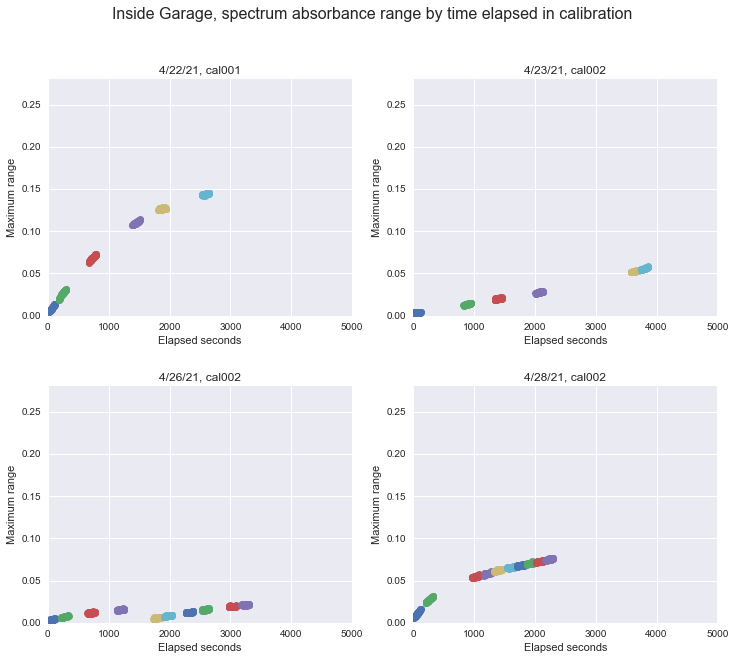

In [5]:
path_name = "/Users/linda/OneDrive/Documents/S4_mine_p/Projects/Data_collected/"
df = pd.read_csv('data/white_insertions.csv')
inside_df = df.loc[df['conditions'] == 'inside'].copy()
calibrations_df = inside_df[['date', 'calibration']].drop_duplicates().copy()
calibrations_count = calibrations_df.shape[0]
records = list(calibrations_df.to_records(index=False))
nrows = (calibrations_count // 2) + (calibrations_count % 2)
fig, axs = plt.subplots(nrows=nrows, ncols=2, figsize=(12, 10))
fig.suptitle("Inside Garage, spectrum absorbance range by time elapsed in calibration", fontsize=16)
for nn, ax in enumerate(axs.flat):
    try:
        date = records[nn][0]
        calibration = records[nn][1]        
        small_df = inside_df.loc[(inside_df['calibration'] == calibration) & (inside_df['date'] == date)].copy()
        file = construct_full_file_path(path_name, small_df['file_name'][small_df.index[0]])
        calibration_path = small_df['session'][small_df.index[0]] + '/' + small_df['calibration'][small_df.index[0]]
        calibration_insertions = create_list_of_insertions_in_calibration(file, calibration_path)
        calibration_date = small_df.iat[0, 1]    
        first_timestamp = get_ftir_spectrum_timestamp(file, calibration_insertions[0], 0)
        ax.set_title(f'{calibration_date}, {calibration}')
        ax.set_ylabel('Maximum range')
        ax.set_xlabel('Elapsed seconds')
        ax.set_ylim(0, 0.28)
        ax.set_xlim(0, 5000)
        for index in small_df.index:  
            insertion_path = calibration_path + '/' + small_df['insertion'][index]
            insertion = small_df['insertion'][index]        
            insertion_start = get_insertion_timestamp(file, insertion_path)
            ftir_waves = get_ftir_wavelength_vector(file, calibration_path)
            start_index = find_position_in_wavelength_vector(ftir_waves, 1200)
            end_index = find_position_in_wavelength_vector(ftir_waves, 2200)
            ftir_raw_spectra = get_ftir_insertion_raw_spectra(file, insertion_path)
            ftir_white_spectrum = get_ftir_white_calibration_curve(file, calibration_path)[start_index:end_index]
            ftir_dark_spectrum = get_ftir_dark_calibration_curve(file, calibration_path)[start_index:end_index]
            ftir_absorbance_spectra = calculate_absorbance_for_2D_array(ftir_raw_spectra[:, start_index:end_index], ftir_white_spectrum, ftir_dark_spectrum)
            insertion_df = pd.DataFrame()

            for i in range(ftir_raw_spectra.shape[0]):
                range_absorbance = np.ptp(ftir_absorbance_spectra[i, :])
                spectrum_timestamp = get_ftir_spectrum_timestamp(file, insertion_path, i)
                time_delta = spectrum_timestamp - first_timestamp
                insertion_df.loc[i, "time_delta"] = time_delta.total_seconds()            
                insertion_df.loc[i, "range_absorbance"] = range_absorbance
            # print(insertion_df.iloc[:, 0])
            ax.plot(insertion_df["time_delta"], insertion_df["range_absorbance"], 'o')
    except:
        pass
    
plt.subplots_adjust(hspace=0.3)
plt.show()
plt.close()

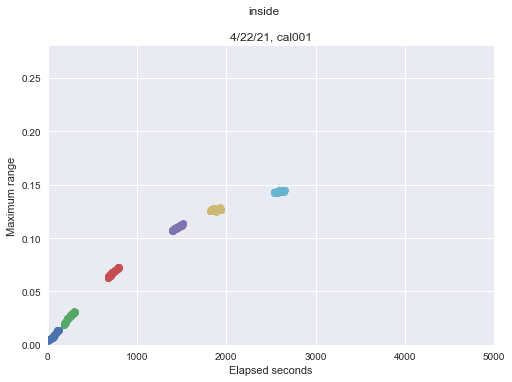

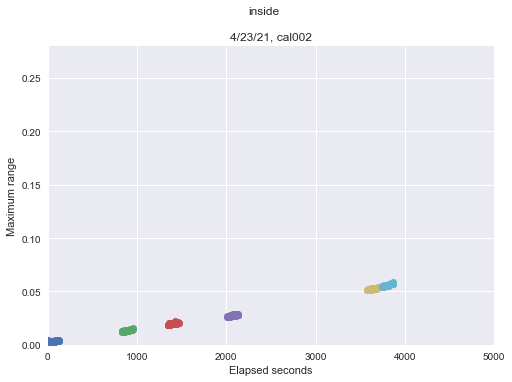

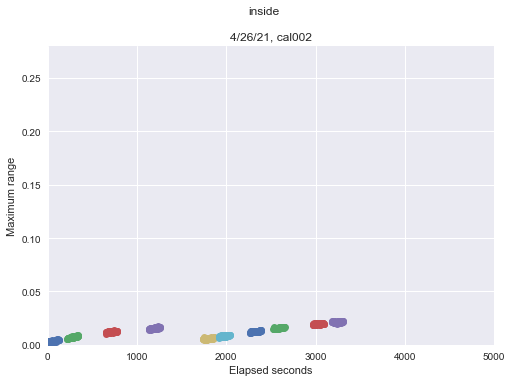

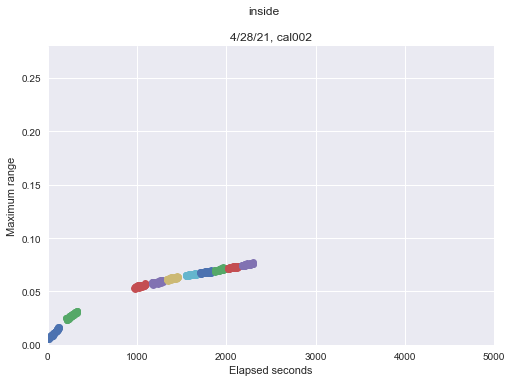

In [37]:

# constants for convenience
ftir_start_wavelength = 1200
ftir_end_wavelength = 2200
vis_start_wavelength = 500
vis_end_wavelength = 1000
# establish data source and type for graph
ftir = True
condition = 'inside'
path_name = "/Users/linda/OneDrive/Documents/S4_mine_p/Projects/Data_collected/"
df = pd.read_csv('data/white_insertions.csv')
inside_df = df.loc[df['conditions'] == 'inside'].copy()
calibrations_df = inside_df[['date', 'calibration']].drop_duplicates().copy()
calibrations_count = calibrations_df.shape[0]
records = list(calibrations_df.to_records(index=False))
for nn, record in enumerate(records):
    date = records[nn][0]
    calibration = records[nn][1]
    small_df = inside_df.loc[(inside_df['calibration'] == calibration) & (inside_df['date'] == date)].copy()
    file = construct_full_file_path(path_name, small_df['file_name'][small_df.index[0]])
    calibration_path = small_df['session'][small_df.index[0]] + '/' + small_df['calibration'][small_df.index[0]]
    calibration_insertions = create_list_of_insertions_in_calibration(file, calibration_path)
    # determine time of first spectrum in the calibration
    first_timestamp = get_ftir_spectrum_timestamp(file, calibration_insertions[0], 0)
    # set up the plot
    fig, ax = plt.subplots()
    fig.suptitle(f'{condition}')
    ax.set_title(f'{date}, {calibration}')
    ax.set_ylabel('Maximum range')
    ax.set_xlabel('Elapsed seconds')
    ax.set_ylim(0, 0.28)
    ax.set_xlim(0, 5000)
    # iterate through the data
    for index in small_df.index:
        # Set up insertion data
        insertion_path = calibration_path + '/' + small_df['insertion'][index]
        insertion = small_df['insertion'][index]
        # Get raw spectra and calibration curves        
        if ftir == True:
            waves = get_ftir_wavelength_vector(file, calibration_path)
            start_index = find_position_in_wavelength_vector(waves, ftir_start_wavelength)
            end_index = find_position_in_wavelength_vector(waves, ftir_end_wavelength)
            raw_spectra = get_ftir_insertion_raw_spectra(file, insertion_path)[:, start_index:end_index]            
            white_spectrum = get_ftir_white_calibration_curve(file, calibration_path)[start_index:end_index]
            dark_spectrum = get_ftir_dark_calibration_curve(file, calibration_path)[start_index:end_index]
            absorbance_spectra = calculate_absorbance_for_2D_array(raw_spectra, white_spectrum, dark_spectrum)
        else:
            waves = get_visible_wavelength_vector(file, calibration_path)
            start_index = find_position_in_wavelength_vector(waves, vis_start_wavelength)
            end_index = find_position_in_wavelength_vector(waves, vis_end_wavelength)
            raw_spectra = get_visible_insertion_raw_spectra(file, insertion_path)[:, start_index:end_index]            
            white_spectrum = get_visible_white_calibration_curve(file, calibration_path)[start_index:end_index]
            dark_spectrum = get_visible_dark_calibration_curve(file, calibration_path)[start_index:end_index]
            absorbance_spectra = calculate_absorbance_for_2D_array(raw_spectra, white_spectrum, dark_spectrum)
        # construct data frame with calculated data for plotting    
        insertion_df = pd.DataFrame()
        for i in range(raw_spectra.shape[0]):
            range_absorbance = np.ptp(absorbance_spectra[i, :])
            spectrum_timestamp = get_ftir_spectrum_timestamp(file, insertion_path, i)
            time_delta = spectrum_timestamp - first_timestamp
            insertion_df.loc[i, "time_delta"] = time_delta.total_seconds()            
            insertion_df.loc[i, "range_absorbance"] = range_absorbance
        # plot the data
        ax.plot(insertion_df["time_delta"], insertion_df["range_absorbance"], 'o')
    plt.show()
    plt.close()
        

In [20]:
print(records)

[('4/22/21', 'cal001'), ('4/23/21', 'cal002'), ('4/26/21', 'cal002'), ('4/28/21', 'cal002')]


In [22]:
small_df

,file_name,date,session,calibration,insertion,conditions
168,210428_green_tests/green_testing_210428.h5,4/28/21,session001,cal002,ins011,inside
169,210428_green_tests/green_testing_210428.h5,4/28/21,session001,cal002,ins012,inside
170,210428_green_tests/green_testing_210428.h5,4/28/21,session001,cal002,ins013,inside
171,210428_green_tests/green_testing_210428.h5,4/28/21,session001,cal002,ins014,inside
172,210428_green_tests/green_testing_210428.h5,4/28/21,session001,cal002,ins015,inside
173,210428_green_tests/green_testing_210428.h5,4/28/21,session001,cal002,ins016,inside
174,210428_green_tests/green_testing_210428.h5,4/28/21,session001,cal002,ins017,inside
175,210428_green_tests/green_testing_210428.h5,4/28/21,session001,cal002,ins018,inside
176,210428_green_tests/green_testing_210428.h5,4/28/21,session001,cal002,ins019,inside
177,210428_green_tests/green_testing_210428.h5,4/28/21,session001,cal002,ins020,inside


In [29]:
small_df['insertion'][small_df.index[1]]

'ins012'

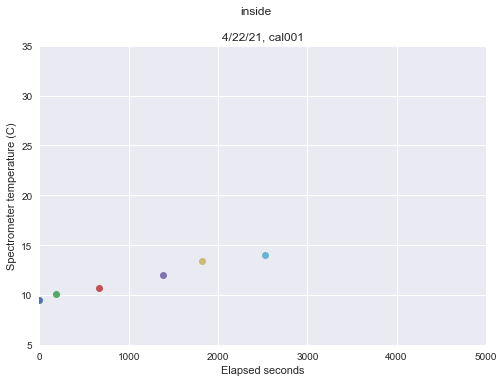

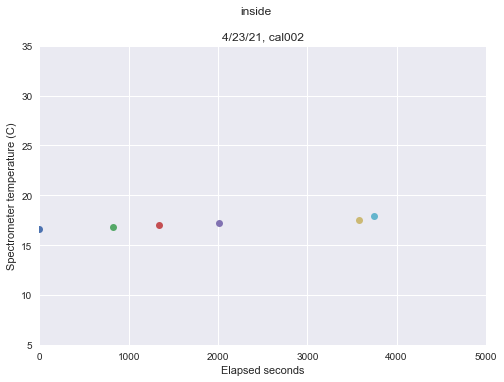

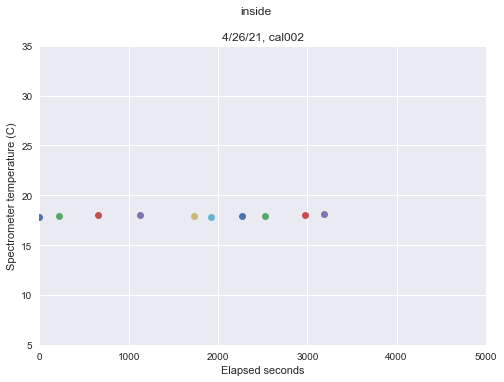

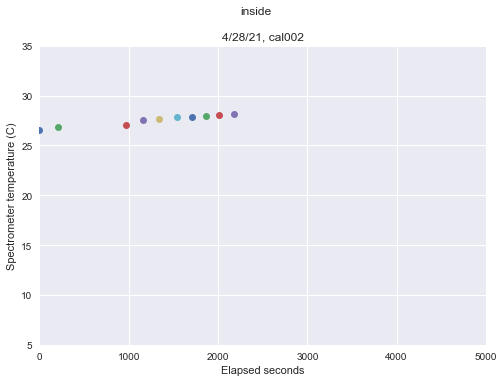

In [54]:
# constants for convenience
ftir_start_wavelength = 1200
ftir_end_wavelength = 2200
vis_start_wavelength = 500
vis_end_wavelength = 1000
# establish data source and type for graph
ftir = True
condition = 'inside'
path_name = "/Users/linda/OneDrive/Documents/S4_mine_p/Projects/Data_collected/"
df = pd.read_csv('data/white_insertions.csv')
inside_df = df.loc[df['conditions'] == 'inside'].copy()
calibrations_df = inside_df[['date', 'calibration']].drop_duplicates().copy()
calibrations_count = calibrations_df.shape[0]
records = list(calibrations_df.to_records(index=False))
for nn, record in enumerate(records):
    date = records[nn][0]
    calibration = records[nn][1]
    small_df = inside_df.loc[(inside_df['calibration'] == calibration) & (inside_df['date'] == date)].copy()
    file = construct_full_file_path(path_name, small_df['file_name'][small_df.index[0]])
    calibration_path = small_df['session'][small_df.index[0]] + '/' + small_df['calibration'][small_df.index[0]]
    calibration_insertions = create_list_of_insertions_in_calibration(file, calibration_path)
    # determine time of first spectrum in the calibration
    first_timestamp = get_ftir_spectrum_timestamp(file, calibration_insertions[0], 0)
    # set up the plot
    fig, ax = plt.subplots()
    fig.suptitle(f'{condition}')
    ax.set_title(f'{date}, {calibration}')
    ax.set_ylabel('Spectrometer temperature (C)')
    ax.set_xlabel('Elapsed seconds')
    ax.set_ylim(5.0, 35.0)
    ax.set_xlim(0, 5000)
    # iterate through the data
    for index in small_df.index:
        # Set up insertion data
        insertion_path = calibration_path + '/' + small_df['insertion'][index]
        insertion = small_df['insertion'][index]
        insertion_temp = get_insertion_temperature(file, insertion_path)
        insertion_timestamp = get_ftir_spectrum_timestamp(file, insertion_path, 0)
        time_delta = (insertion_timestamp - first_timestamp).total_seconds()
        ax.plot(time_delta, insertion_temp, 'o')
        
    plt.show()
    plt.close()

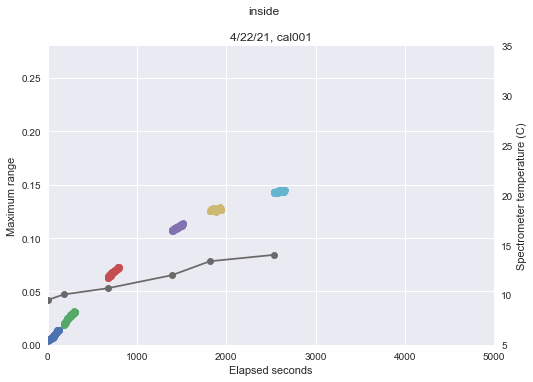

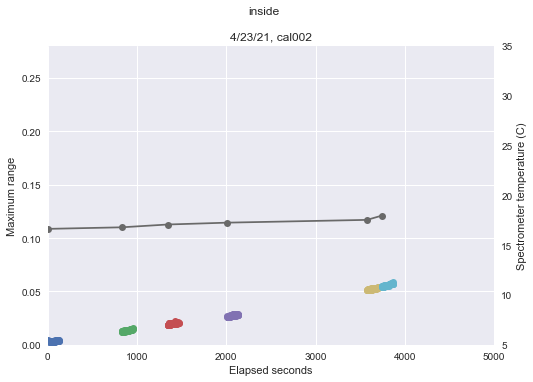

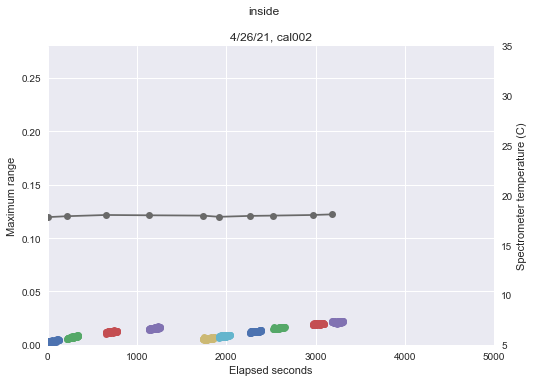

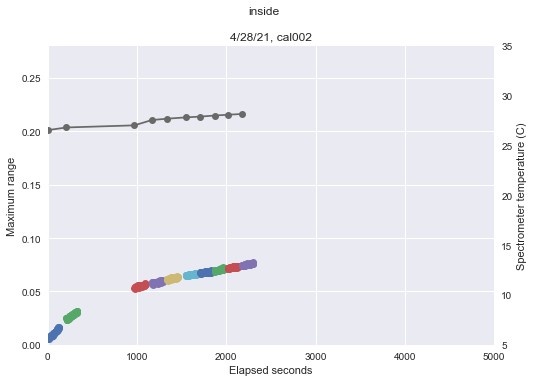

In [76]:
# constants for convenience
ftir_start_wavelength = 1200
ftir_end_wavelength = 2200
vis_start_wavelength = 500
vis_end_wavelength = 1000
# establish data source and type for graph
ftir = True
condition = 'inside'
path_name = "/Users/linda/OneDrive/Documents/S4_mine_p/Projects/Data_collected/"
df = pd.read_csv('data/white_insertions.csv')
inside_df = df.loc[df['conditions'] == 'inside'].copy()
calibrations_df = inside_df[['date', 'calibration']].drop_duplicates().copy()
calibrations_count = calibrations_df.shape[0]
records = list(calibrations_df.to_records(index=False))
for nn, record in enumerate(records):
    date = records[nn][0]
    calibration = records[nn][1]
    small_df = inside_df.loc[(inside_df['calibration'] == calibration) & (inside_df['date'] == date)].copy()
    file = construct_full_file_path(path_name, small_df['file_name'][small_df.index[0]])
    calibration_path = small_df['session'][small_df.index[0]] + '/' + small_df['calibration'][small_df.index[0]]
    calibration_insertions = create_list_of_insertions_in_calibration(file, calibration_path)
    # determine time of first spectrum in the calibration
    first_timestamp = get_ftir_spectrum_timestamp(file, calibration_insertions[0], 0)
    # set up the plot
    fig, ax = plt.subplots()
    fig.suptitle(f'{condition}')
    ax.set_title(f'{date}, {calibration}')
    ax.set_ylabel('Maximum range')
    ax.set_xlabel('Elapsed seconds')
    ax.set_ylim(0, 0.28)
    ax.set_xlim(0, 5000)
    ax2 = ax.twinx()
    ax2.set_ylabel('Spectrometer temperature (C)')
    
    ax2.set_ylim(5.0, 35.0)
    ax2.set_xlim(0, 5000)
    ax2.grid(b=None)
    
    temperature_df = pd.DataFrame()
    
    # iterate through the data
    for index in small_df.index:
        # Set up insertion data
        insertion_path = calibration_path + '/' + small_df['insertion'][index]
        insertion = small_df['insertion'][index]
        insertion = small_df['insertion'][index]
        
        temperature_df.loc[index, 'insertion_temp'] = get_insertion_temperature(file, insertion_path)
        insertion_timestamp = get_ftir_spectrum_timestamp(file, insertion_path, 0)
        temperature_df.loc[index, 'time_delta'] = (insertion_timestamp - first_timestamp).total_seconds()
        
        # Get raw spectra and calibration curves        
        if ftir == True:
            waves = get_ftir_wavelength_vector(file, calibration_path)
            start_index = find_position_in_wavelength_vector(waves, ftir_start_wavelength)
            end_index = find_position_in_wavelength_vector(waves, ftir_end_wavelength)
            raw_spectra = get_ftir_insertion_raw_spectra(file, insertion_path)[:, start_index:end_index]            
            white_spectrum = get_ftir_white_calibration_curve(file, calibration_path)[start_index:end_index]
            dark_spectrum = get_ftir_dark_calibration_curve(file, calibration_path)[start_index:end_index]
            absorbance_spectra = calculate_absorbance_for_2D_array(raw_spectra, white_spectrum, dark_spectrum)
        else:
            waves = get_visible_wavelength_vector(file, calibration_path)
            start_index = find_position_in_wavelength_vector(waves, vis_start_wavelength)
            end_index = find_position_in_wavelength_vector(waves, vis_end_wavelength)
            raw_spectra = get_visible_insertion_raw_spectra(file, insertion_path)[:, start_index:end_index]            
            white_spectrum = get_visible_white_calibration_curve(file, calibration_path)[start_index:end_index]
            dark_spectrum = get_visible_dark_calibration_curve(file, calibration_path)[start_index:end_index]
            absorbance_spectra = calculate_absorbance_for_2D_array(raw_spectra, white_spectrum, dark_spectrum)
        # construct data frame with calculated data for plotting    
        insertion_df = pd.DataFrame()
        for i in range(raw_spectra.shape[0]):
            range_absorbance = np.ptp(absorbance_spectra[i, :])
            spectrum_timestamp = get_ftir_spectrum_timestamp(file, insertion_path, i)
            time_delta = spectrum_timestamp - first_timestamp
            insertion_df.loc[i, "time_delta"] = time_delta.total_seconds()            
            insertion_df.loc[i, "range_absorbance"] = range_absorbance
        # plot the data
        ax.plot(insertion_df["time_delta"], insertion_df["range_absorbance"], 'o')
    ax2.plot(temperature_df["time_delta"], temperature_df["insertion_temp"], 'dimgray', marker='o')
    plt.show()
    plt.close()

In [77]:
df['conditions'].unique()

array(['general', 'lamp warming', 'outside', 'inside',
       'heat spectrometer', 'cool spectrometer', 'heat light source',
       'outside lamp warming', 'sunshine', 'sunshine box', 'overcast',
       'overcast box'], dtype=object)

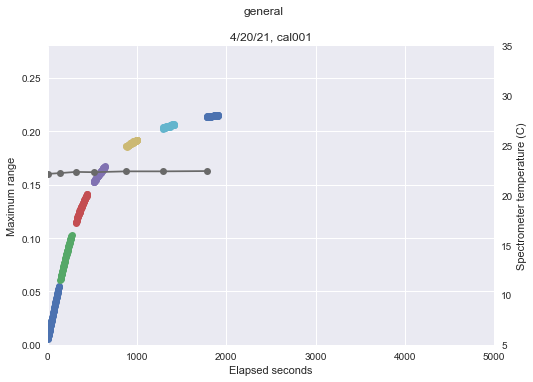

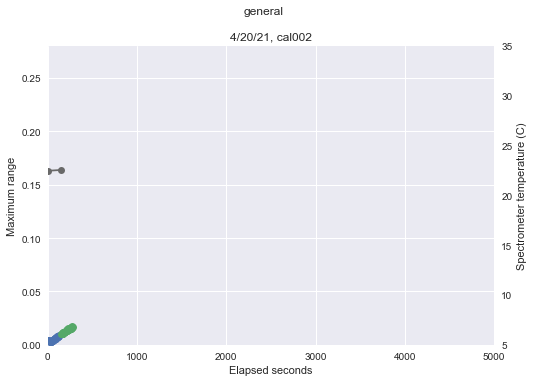

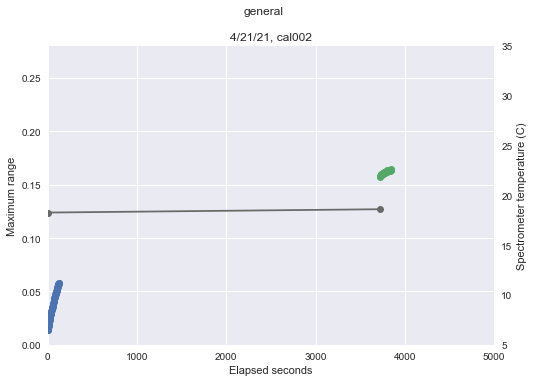

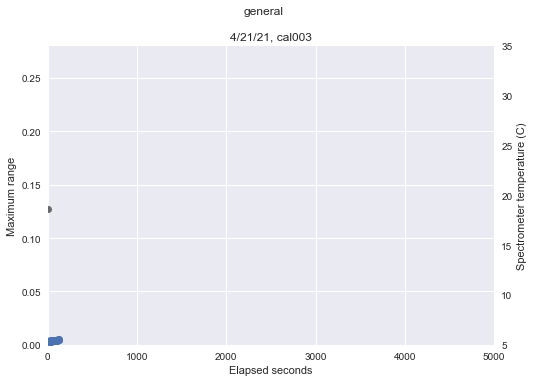

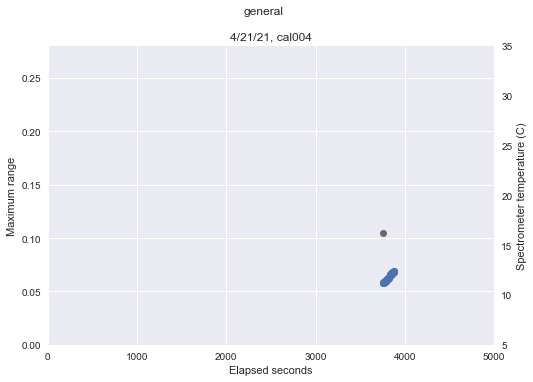

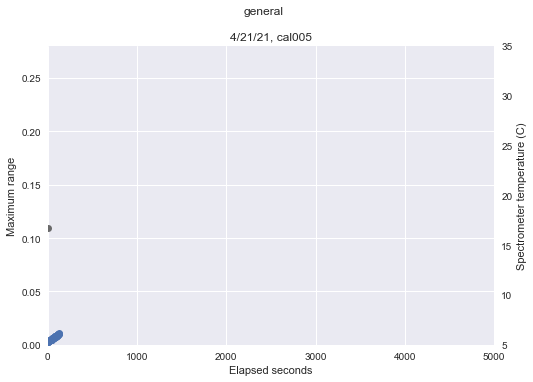

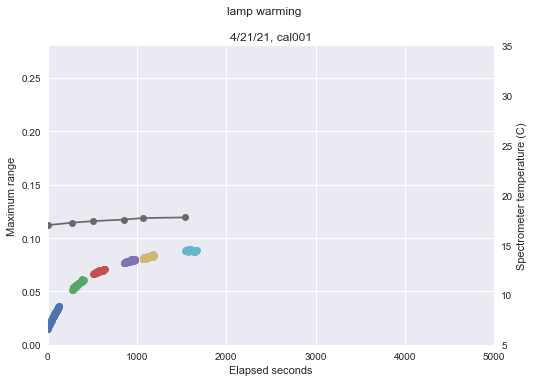

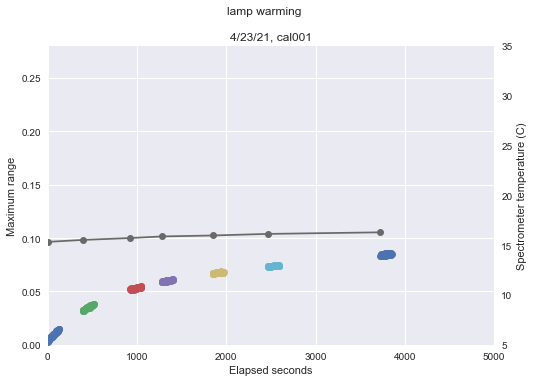

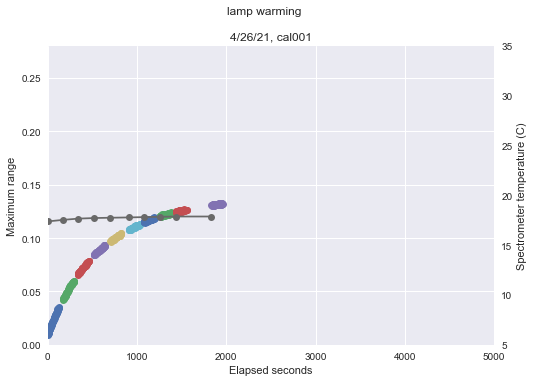

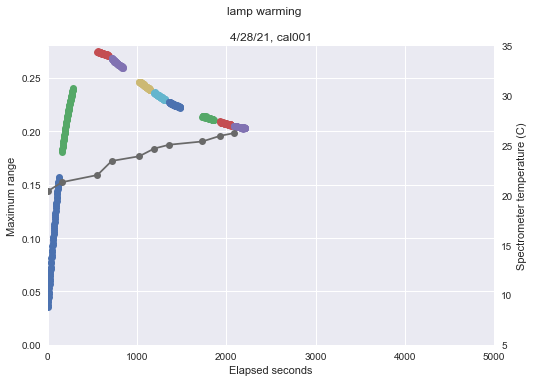

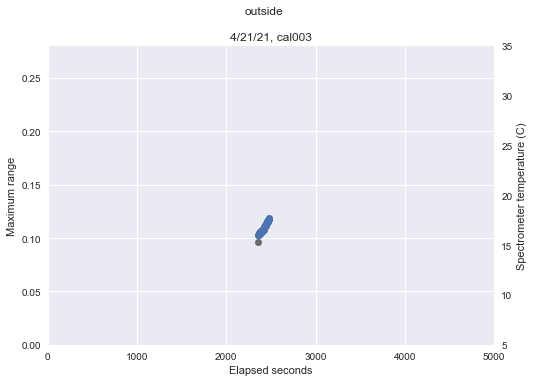

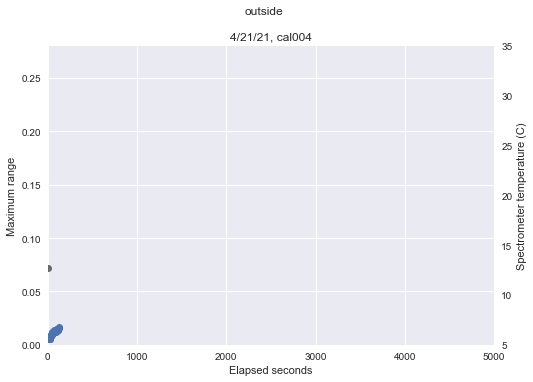

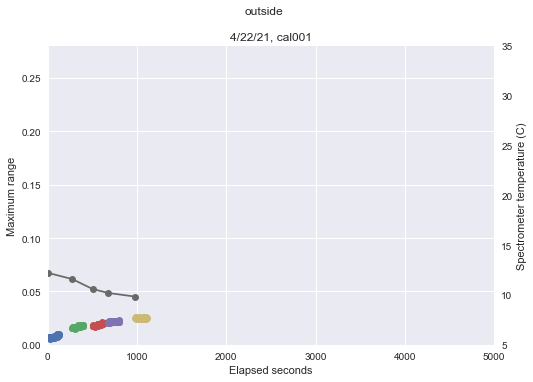

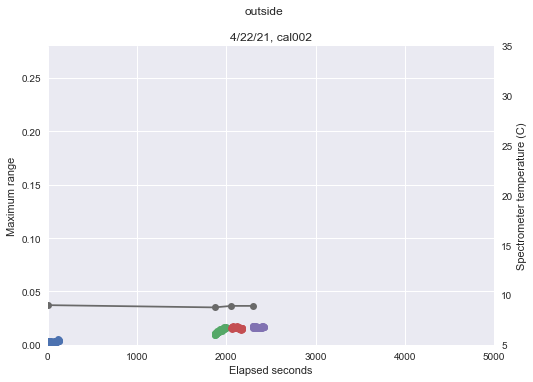

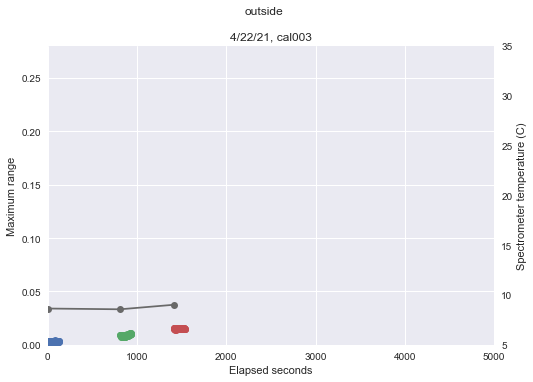

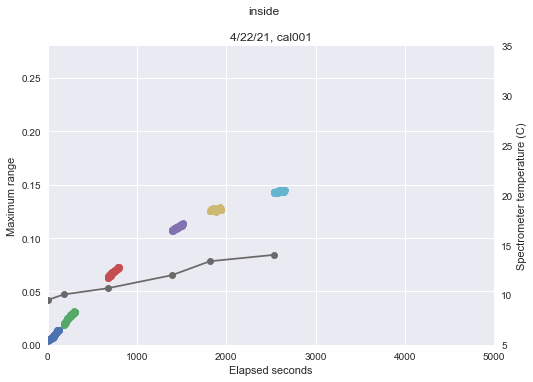

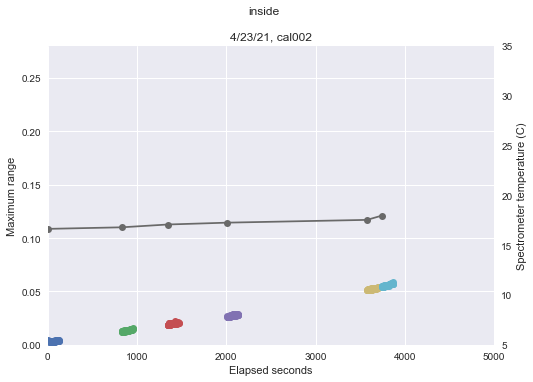

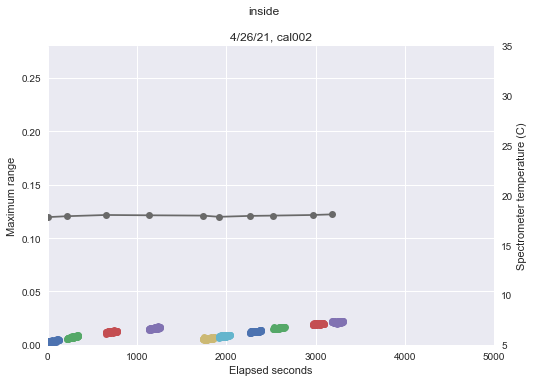

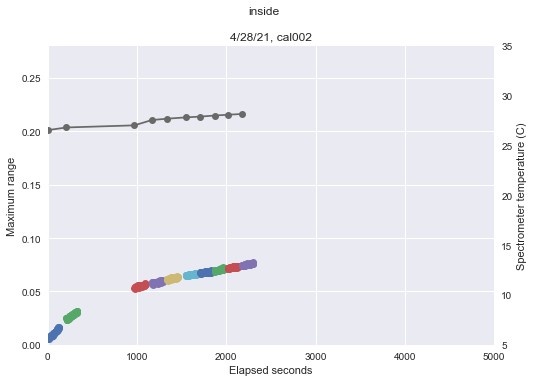

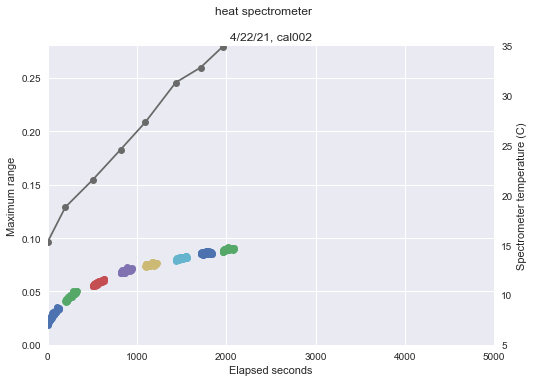

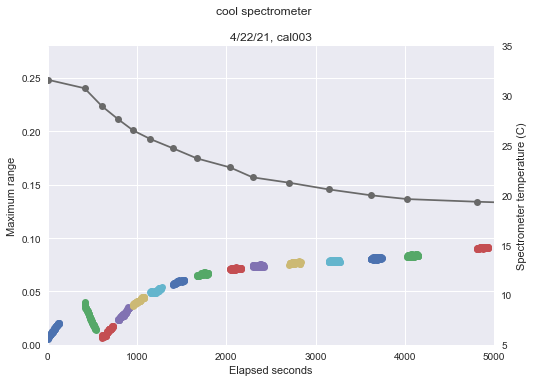

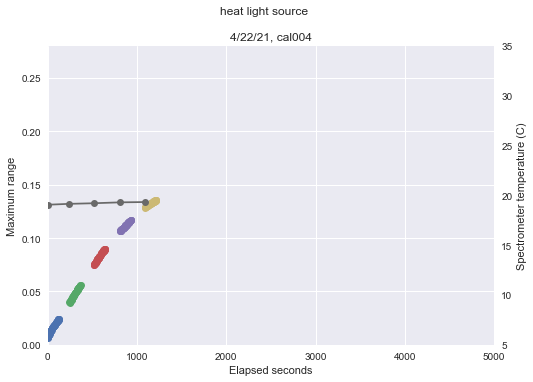

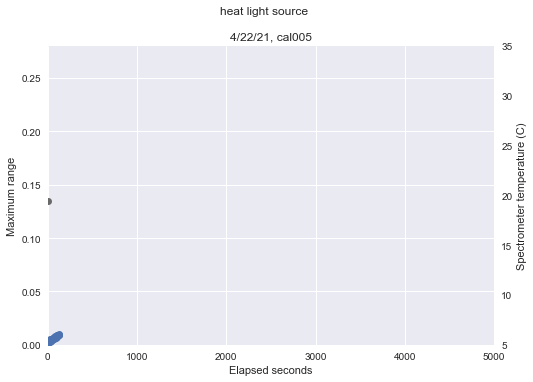

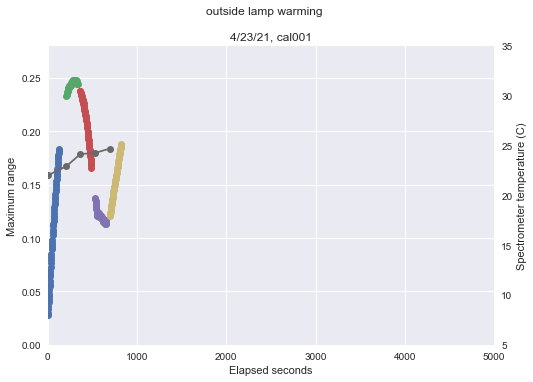

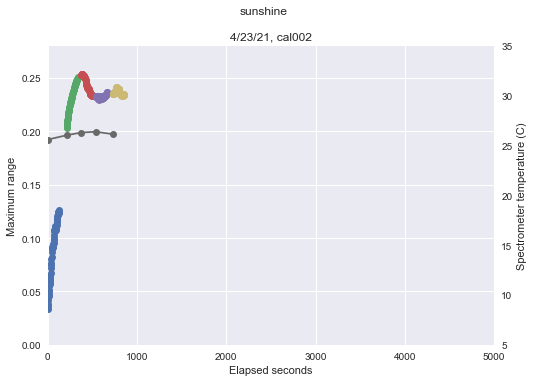

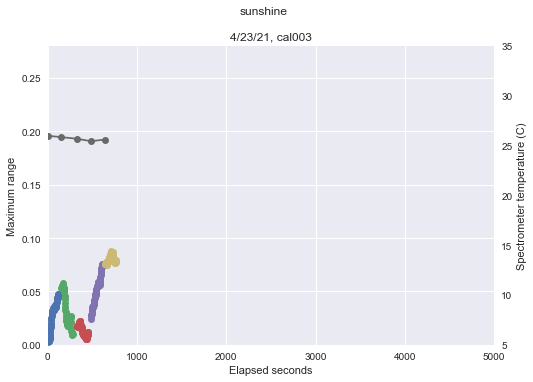

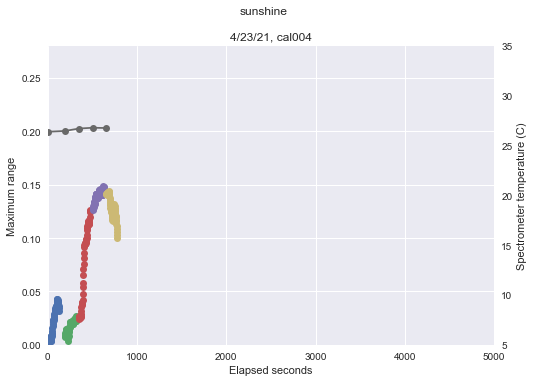

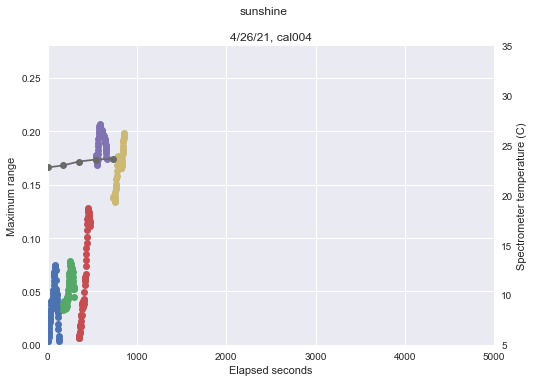

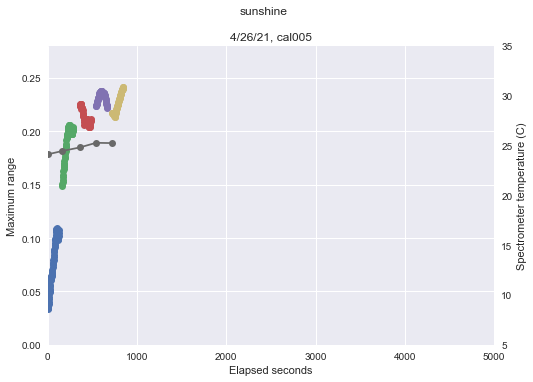

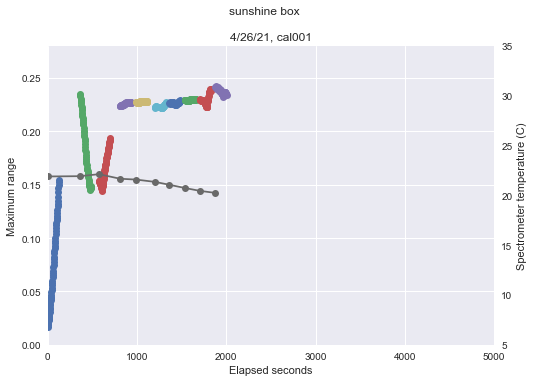

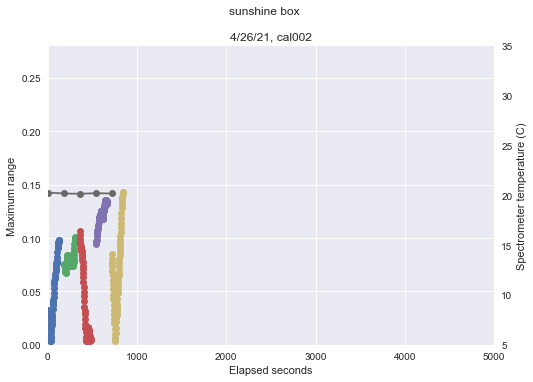

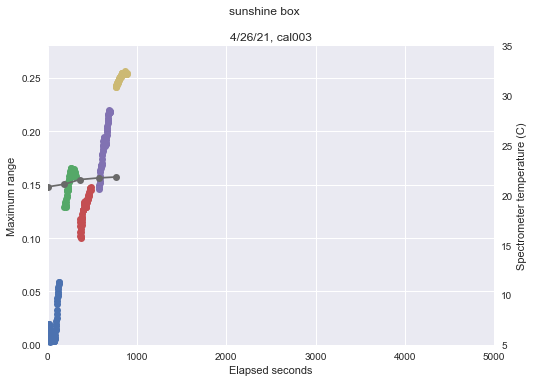

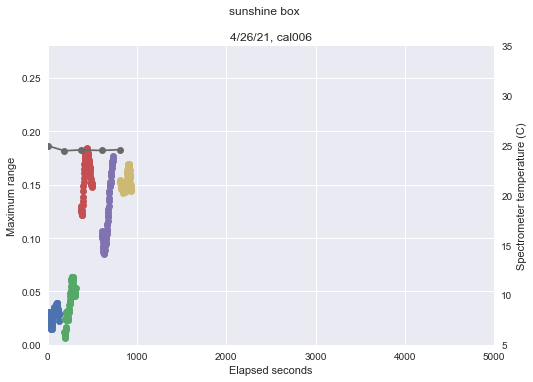

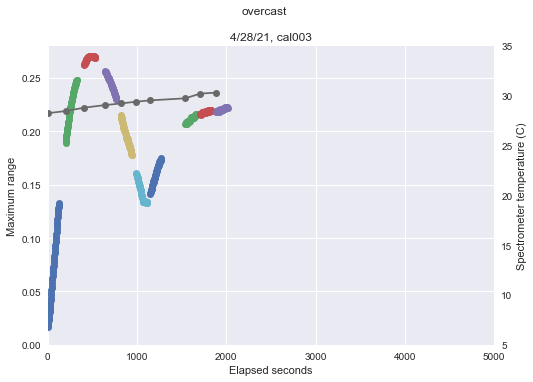

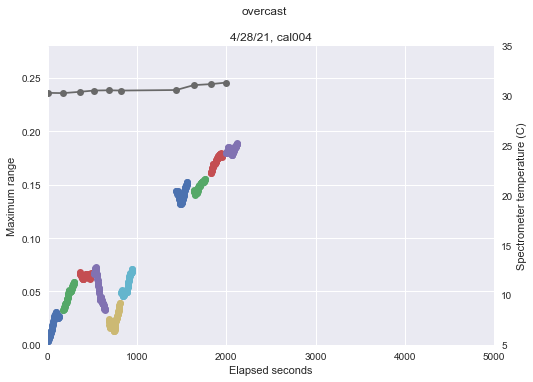

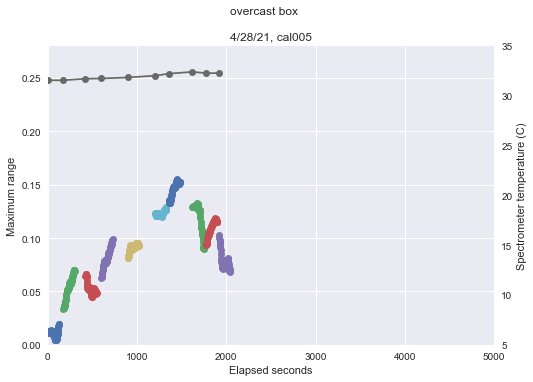

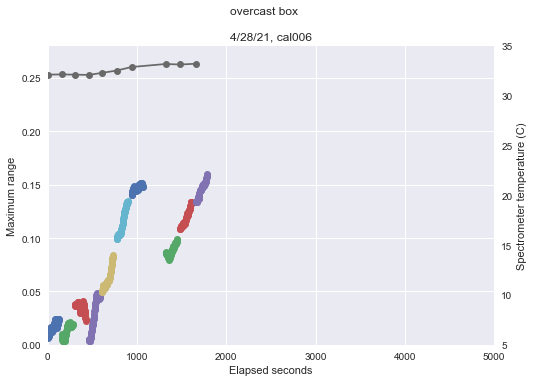

In [78]:
# constants for convenience
ftir_start_wavelength = 1200
ftir_end_wavelength = 2200
vis_start_wavelength = 500
vis_end_wavelength = 1000
# establish data source and type for graph
ftir = True

path_name = "/Users/linda/OneDrive/Documents/S4_mine_p/Projects/Data_collected/"
df = pd.read_csv('data/white_insertions.csv')
conditions = df['conditions'].unique()
for condition in conditions:
    inside_df = df.loc[df['conditions'] == condition].copy()
    calibrations_df = inside_df[['date', 'calibration']].drop_duplicates().copy()
    calibrations_count = calibrations_df.shape[0]
    records = list(calibrations_df.to_records(index=False))
    for nn, record in enumerate(records):
        date = records[nn][0]
        calibration = records[nn][1]
        small_df = inside_df.loc[(inside_df['calibration'] == calibration) & (inside_df['date'] == date)].copy()
        file = construct_full_file_path(path_name, small_df['file_name'][small_df.index[0]])
        calibration_path = small_df['session'][small_df.index[0]] + '/' + small_df['calibration'][small_df.index[0]]
        calibration_insertions = create_list_of_insertions_in_calibration(file, calibration_path)
        # determine time of first spectrum in the calibration
        first_timestamp = get_ftir_spectrum_timestamp(file, calibration_insertions[0], 0)
        # set up the plot
        fig, ax = plt.subplots()
        fig.suptitle(f'{condition}')
        ax.set_title(f'{date}, {calibration}')
        ax.set_ylabel('Maximum range')
        ax.set_xlabel('Elapsed seconds')
        ax.set_ylim(0, 0.28)
        ax.set_xlim(0, 5000)
        ax2 = ax.twinx()
        ax2.set_ylabel('Spectrometer temperature (C)')

        ax2.set_ylim(5.0, 35.0)
        ax2.set_xlim(0, 5000)
        ax2.grid(b=None)

        temperature_df = pd.DataFrame()

        # iterate through the data
        for index in small_df.index:
            # Set up insertion data
            insertion_path = calibration_path + '/' + small_df['insertion'][index]
            insertion = small_df['insertion'][index]
            insertion = small_df['insertion'][index]

            temperature_df.loc[index, 'insertion_temp'] = get_insertion_temperature(file, insertion_path)
            insertion_timestamp = get_ftir_spectrum_timestamp(file, insertion_path, 0)
            temperature_df.loc[index, 'time_delta'] = (insertion_timestamp - first_timestamp).total_seconds()

            # Get raw spectra and calibration curves        
            if ftir == True:
                waves = get_ftir_wavelength_vector(file, calibration_path)
                start_index = find_position_in_wavelength_vector(waves, ftir_start_wavelength)
                end_index = find_position_in_wavelength_vector(waves, ftir_end_wavelength)
                raw_spectra = get_ftir_insertion_raw_spectra(file, insertion_path)[:, start_index:end_index]            
                white_spectrum = get_ftir_white_calibration_curve(file, calibration_path)[start_index:end_index]
                dark_spectrum = get_ftir_dark_calibration_curve(file, calibration_path)[start_index:end_index]
                absorbance_spectra = calculate_absorbance_for_2D_array(raw_spectra, white_spectrum, dark_spectrum)
            else:
                waves = get_visible_wavelength_vector(file, calibration_path)
                start_index = find_position_in_wavelength_vector(waves, vis_start_wavelength)
                end_index = find_position_in_wavelength_vector(waves, vis_end_wavelength)
                raw_spectra = get_visible_insertion_raw_spectra(file, insertion_path)[:, start_index:end_index]            
                white_spectrum = get_visible_white_calibration_curve(file, calibration_path)[start_index:end_index]
                dark_spectrum = get_visible_dark_calibration_curve(file, calibration_path)[start_index:end_index]
                absorbance_spectra = calculate_absorbance_for_2D_array(raw_spectra, white_spectrum, dark_spectrum)
            # construct data frame with calculated data for plotting    
            insertion_df = pd.DataFrame()
            for i in range(raw_spectra.shape[0]):
                range_absorbance = np.ptp(absorbance_spectra[i, :])
                spectrum_timestamp = get_ftir_spectrum_timestamp(file, insertion_path, i)
                time_delta = spectrum_timestamp - first_timestamp
                insertion_df.loc[i, "time_delta"] = time_delta.total_seconds()            
                insertion_df.loc[i, "range_absorbance"] = range_absorbance
            # plot the data
            ax.plot(insertion_df["time_delta"], insertion_df["range_absorbance"], 'o')
        ax2.plot(temperature_df["time_delta"], temperature_df["insertion_temp"], 'dimgray', marker='o')
        plt.show()
        plt.close()

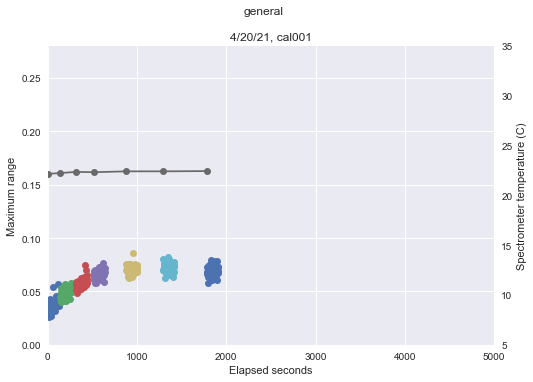

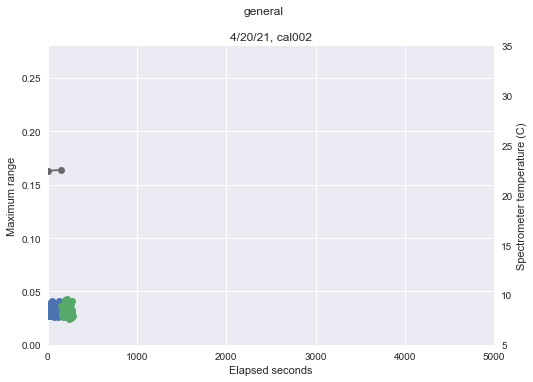

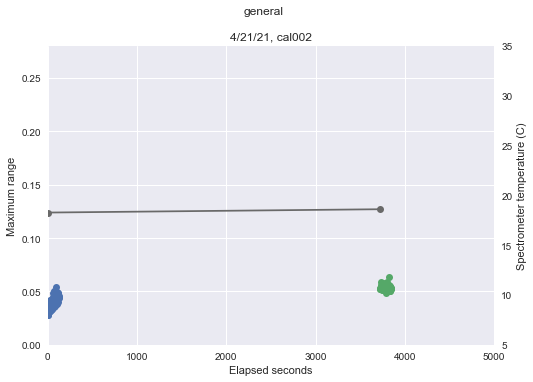

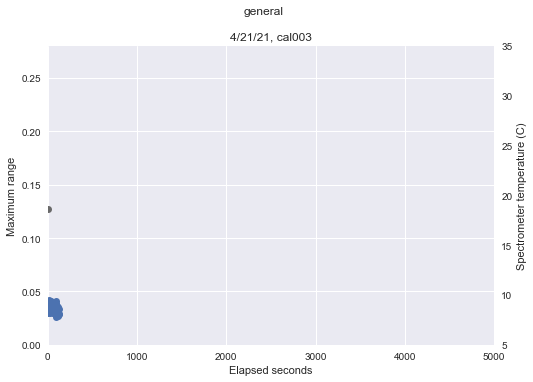

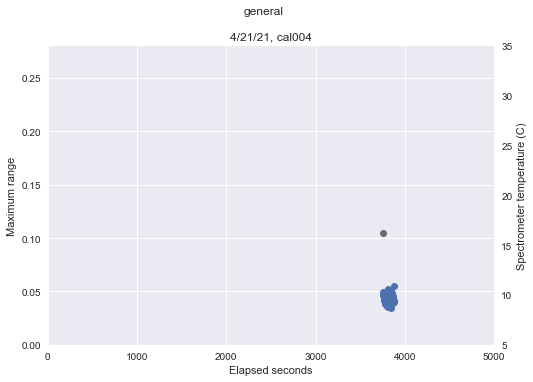

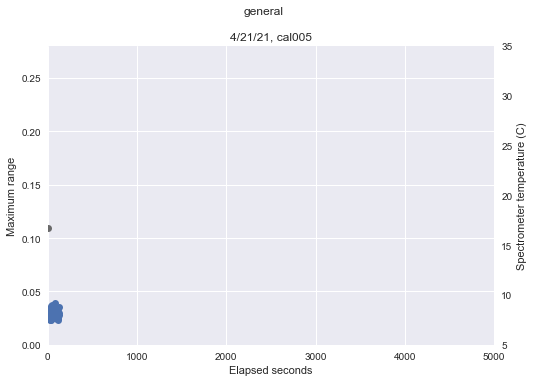

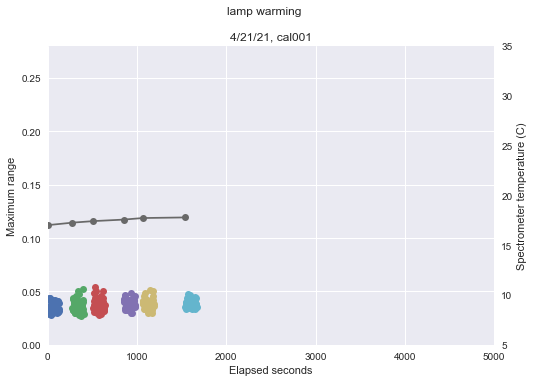

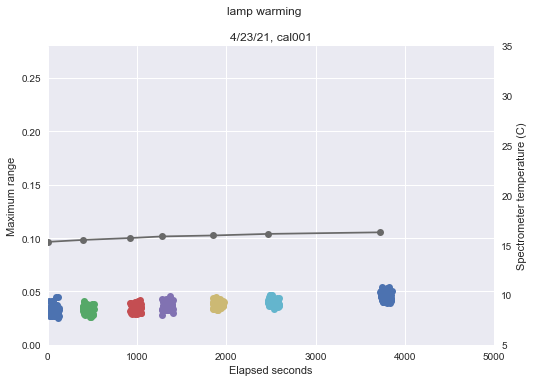

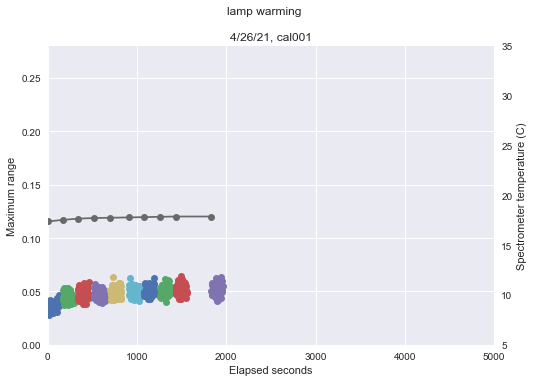

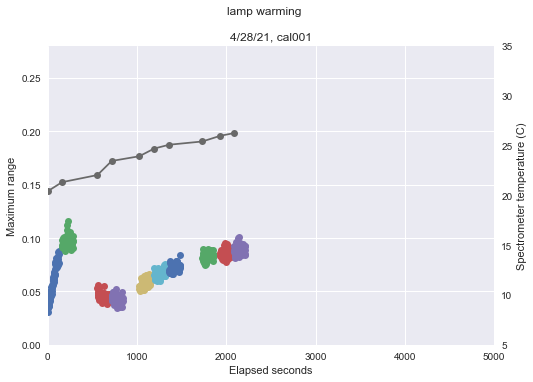

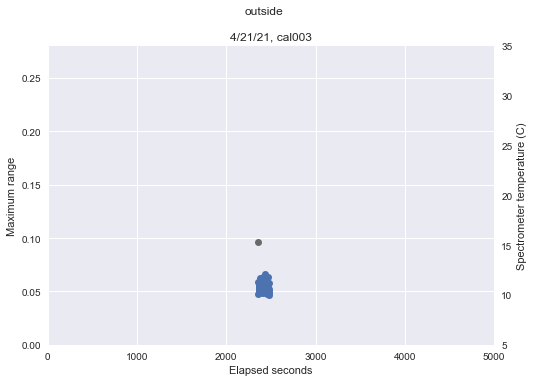

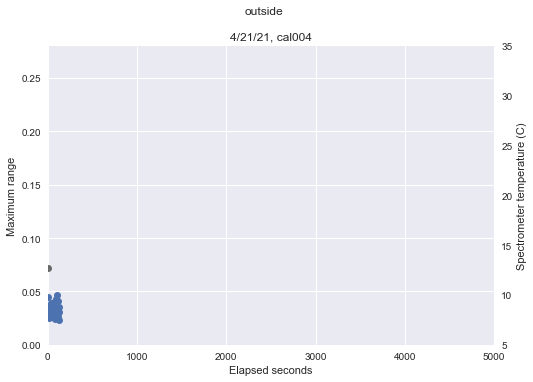

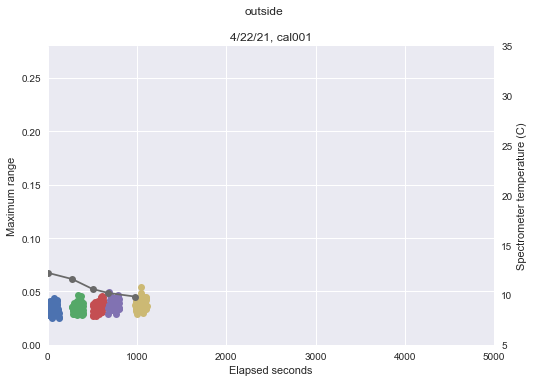

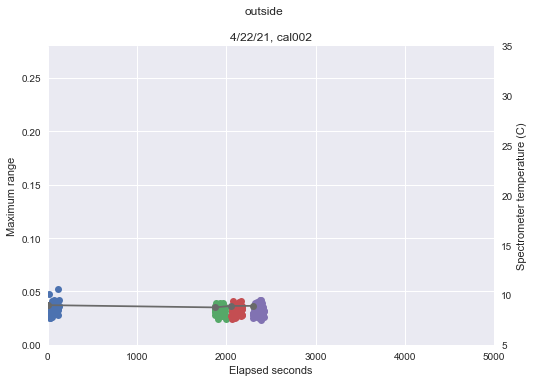

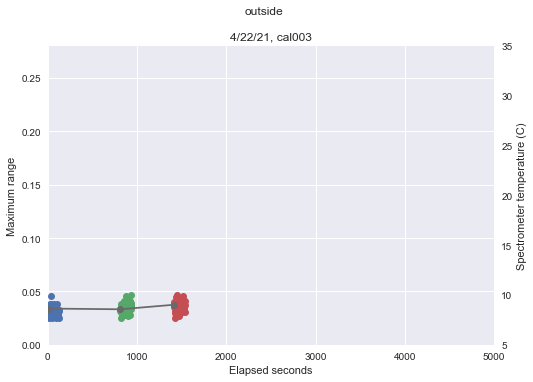

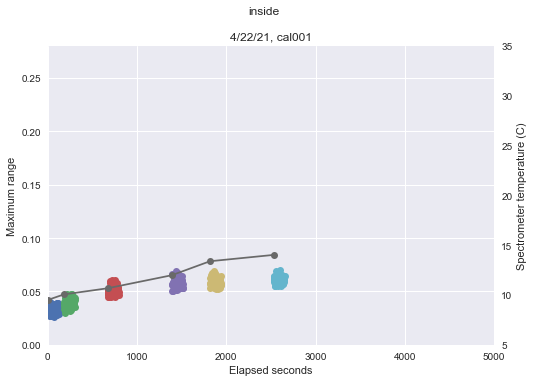

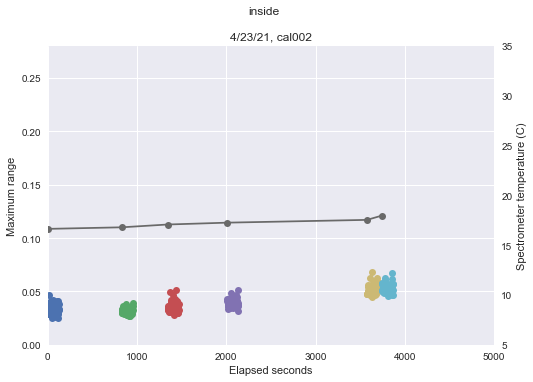

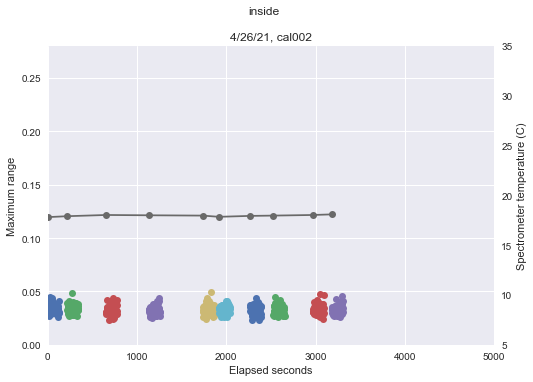

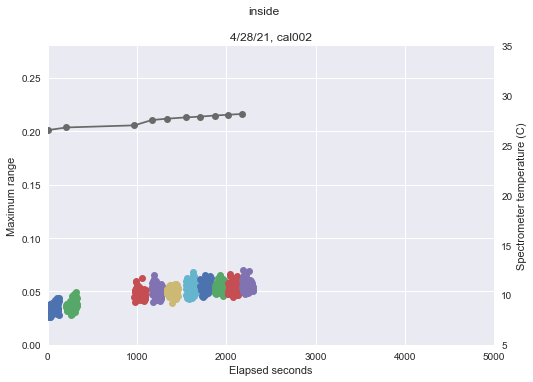

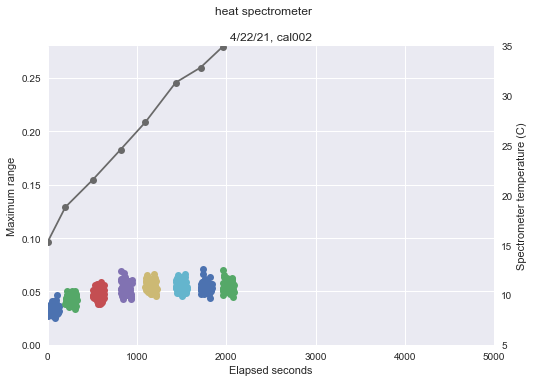

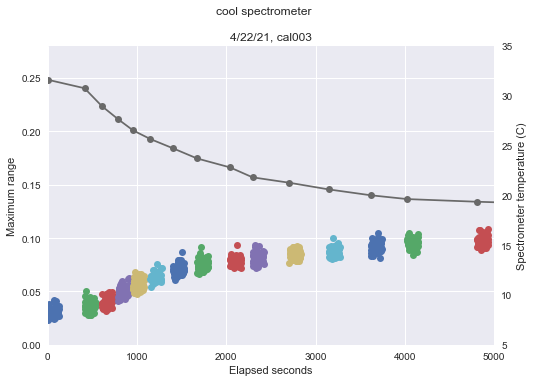

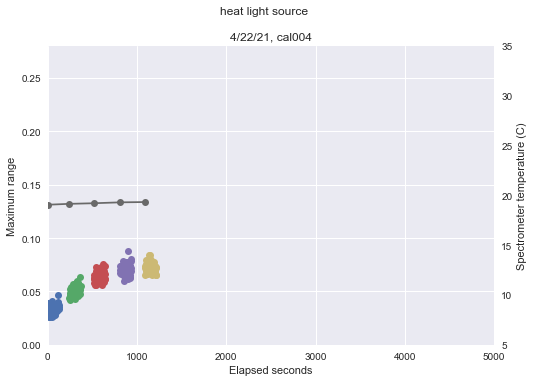

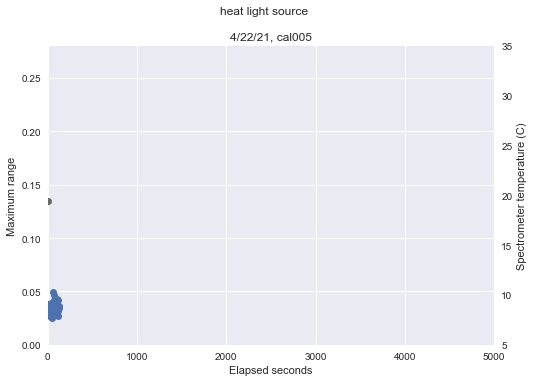

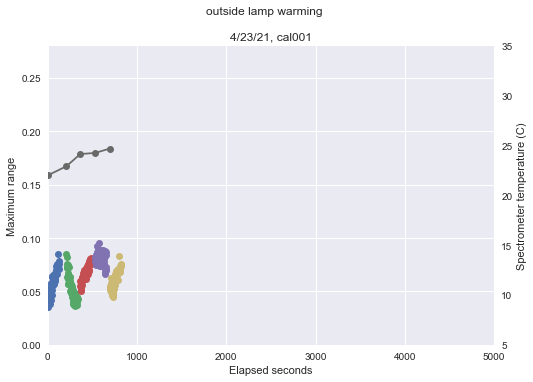

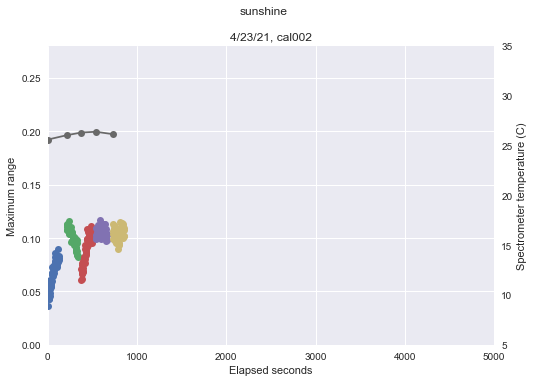

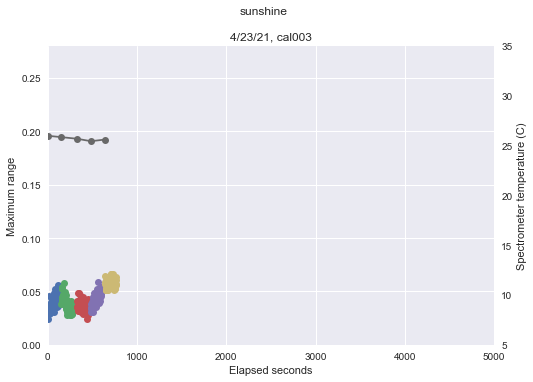

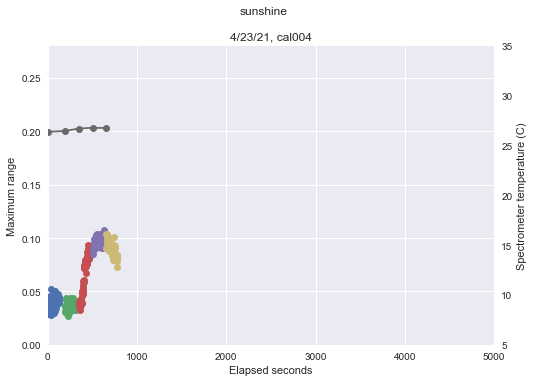

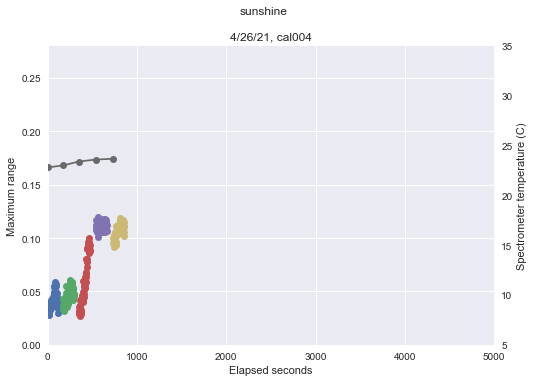

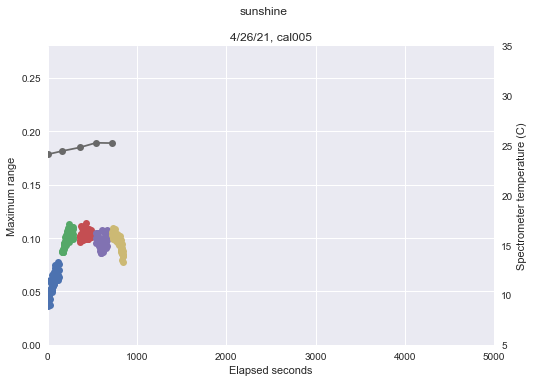

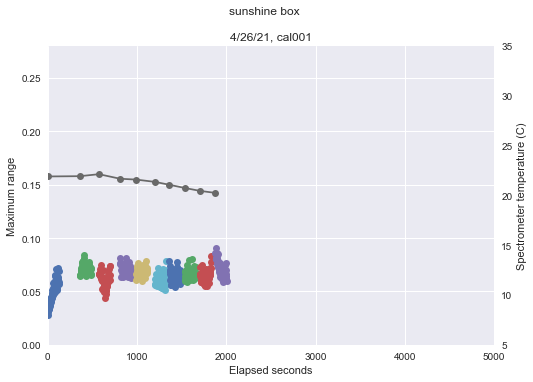

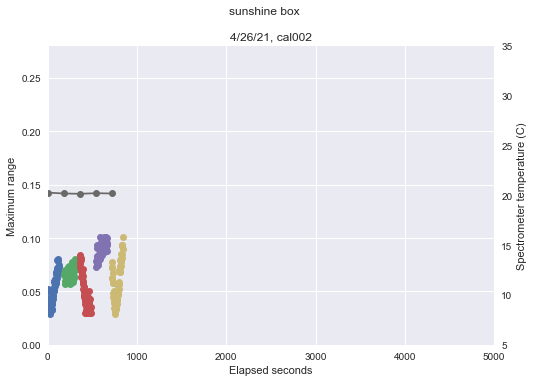

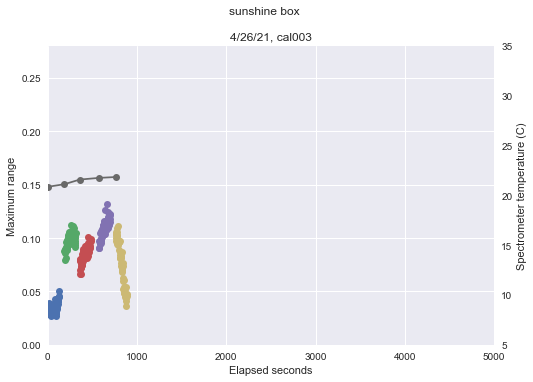

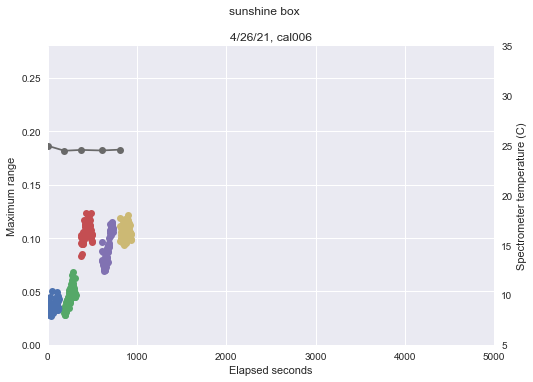

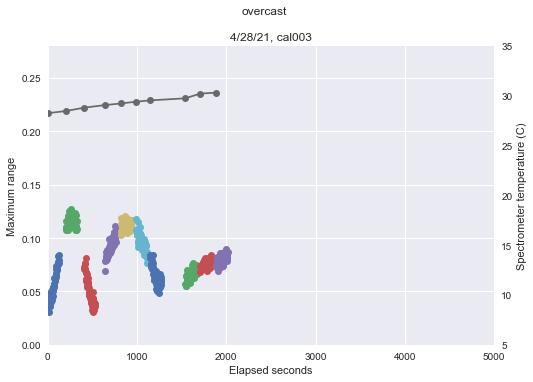

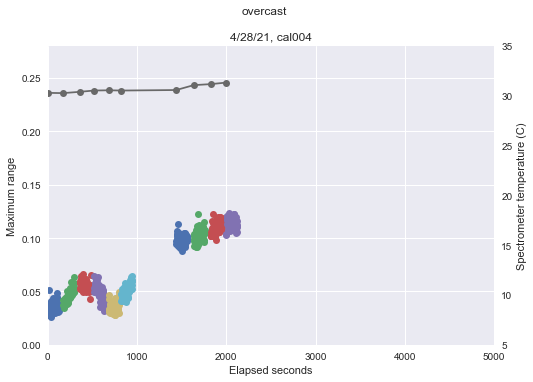

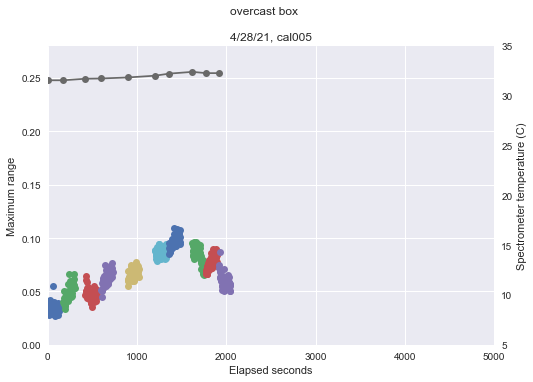

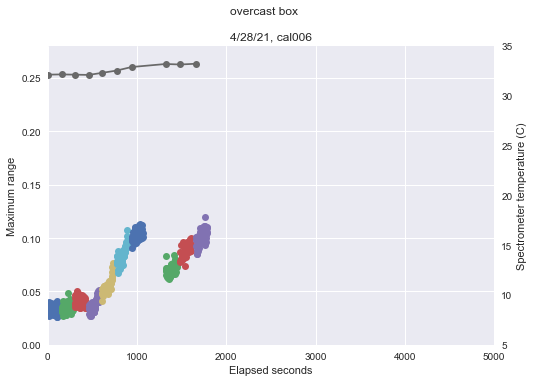

In [79]:
# constants for convenience
ftir_start_wavelength = 1200
ftir_end_wavelength = 2200
vis_start_wavelength = 500
vis_end_wavelength = 1000
# establish data source and type for graph
ftir = False

path_name = "/Users/linda/OneDrive/Documents/S4_mine_p/Projects/Data_collected/"
df = pd.read_csv('data/white_insertions.csv')
conditions = df['conditions'].unique()
for condition in conditions:
    inside_df = df.loc[df['conditions'] == condition].copy()
    calibrations_df = inside_df[['date', 'calibration']].drop_duplicates().copy()
    calibrations_count = calibrations_df.shape[0]
    records = list(calibrations_df.to_records(index=False))
    for nn, record in enumerate(records):
        date = records[nn][0]
        calibration = records[nn][1]
        small_df = inside_df.loc[(inside_df['calibration'] == calibration) & (inside_df['date'] == date)].copy()
        file = construct_full_file_path(path_name, small_df['file_name'][small_df.index[0]])
        calibration_path = small_df['session'][small_df.index[0]] + '/' + small_df['calibration'][small_df.index[0]]
        calibration_insertions = create_list_of_insertions_in_calibration(file, calibration_path)
        # determine time of first spectrum in the calibration
        first_timestamp = get_ftir_spectrum_timestamp(file, calibration_insertions[0], 0)
        # set up the plot
        fig, ax = plt.subplots()
        fig.suptitle(f'{condition}')
        ax.set_title(f'{date}, {calibration}')
        ax.set_ylabel('Maximum range')
        ax.set_xlabel('Elapsed seconds')
        ax.set_ylim(0, 0.28)
        ax.set_xlim(0, 5000)
        ax2 = ax.twinx()
        ax2.set_ylabel('Spectrometer temperature (C)')

        ax2.set_ylim(5.0, 35.0)
        ax2.set_xlim(0, 5000)
        ax2.grid(b=None)

        temperature_df = pd.DataFrame()

        # iterate through the data
        for index in small_df.index:
            # Set up insertion data
            insertion_path = calibration_path + '/' + small_df['insertion'][index]
            insertion = small_df['insertion'][index]
            insertion = small_df['insertion'][index]

            temperature_df.loc[index, 'insertion_temp'] = get_insertion_temperature(file, insertion_path)
            insertion_timestamp = get_ftir_spectrum_timestamp(file, insertion_path, 0)
            temperature_df.loc[index, 'time_delta'] = (insertion_timestamp - first_timestamp).total_seconds()

            # Get raw spectra and calibration curves        
            if ftir == True:
                waves = get_ftir_wavelength_vector(file, calibration_path)
                start_index = find_position_in_wavelength_vector(waves, ftir_start_wavelength)
                end_index = find_position_in_wavelength_vector(waves, ftir_end_wavelength)
                raw_spectra = get_ftir_insertion_raw_spectra(file, insertion_path)[:, start_index:end_index]            
                white_spectrum = get_ftir_white_calibration_curve(file, calibration_path)[start_index:end_index]
                dark_spectrum = get_ftir_dark_calibration_curve(file, calibration_path)[start_index:end_index]
                absorbance_spectra = calculate_absorbance_for_2D_array(raw_spectra, white_spectrum, dark_spectrum)
            else:
                waves = get_visible_wavelength_vector(file, calibration_path)
                start_index = find_position_in_wavelength_vector(waves, vis_start_wavelength)
                end_index = find_position_in_wavelength_vector(waves, vis_end_wavelength)
                raw_spectra = get_visible_insertion_raw_spectra(file, insertion_path)[:, start_index:end_index]            
                white_spectrum = get_visible_white_calibration_curve(file, calibration_path)[start_index:end_index]
                dark_spectrum = get_visible_dark_calibration_curve(file, calibration_path)[start_index:end_index]
                absorbance_spectra = calculate_absorbance_for_2D_array(raw_spectra, white_spectrum, dark_spectrum)
            # construct data frame with calculated data for plotting    
            insertion_df = pd.DataFrame()
            for i in range(raw_spectra.shape[0]):
                range_absorbance = np.ptp(absorbance_spectra[i, :])
                spectrum_timestamp = get_ftir_spectrum_timestamp(file, insertion_path, i)
                time_delta = spectrum_timestamp - first_timestamp
                insertion_df.loc[i, "time_delta"] = time_delta.total_seconds()            
                insertion_df.loc[i, "range_absorbance"] = range_absorbance
            # plot the data
            ax.plot(insertion_df["time_delta"], insertion_df["range_absorbance"], 'o')
        ax2.plot(temperature_df["time_delta"], temperature_df["insertion_temp"], 'dimgray', marker='o')
        plt.show()
        plt.close()

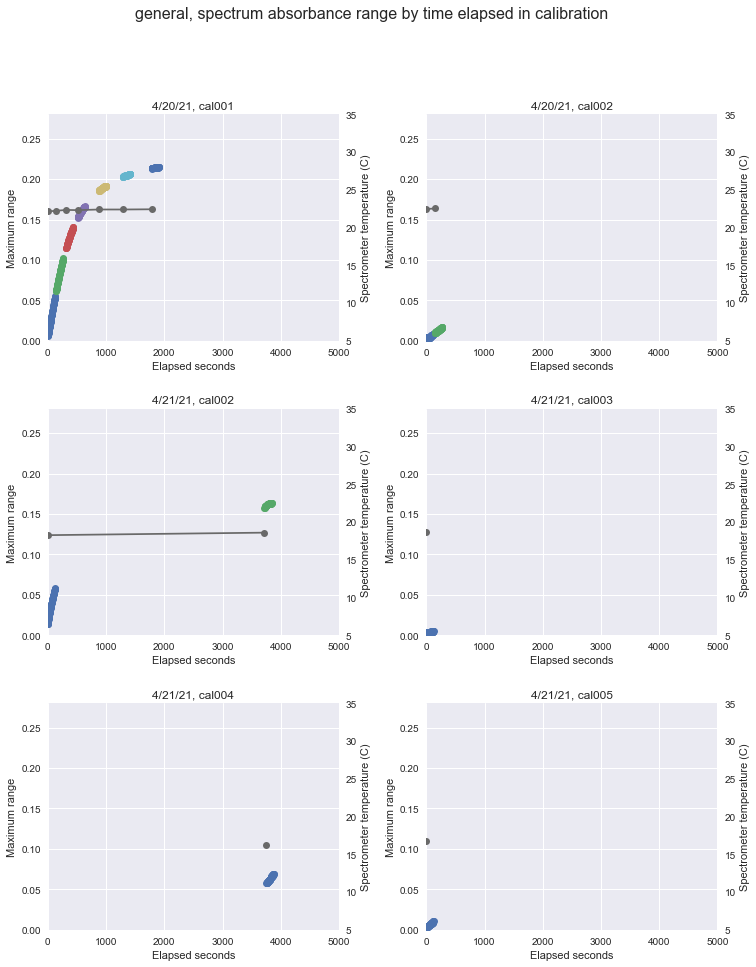

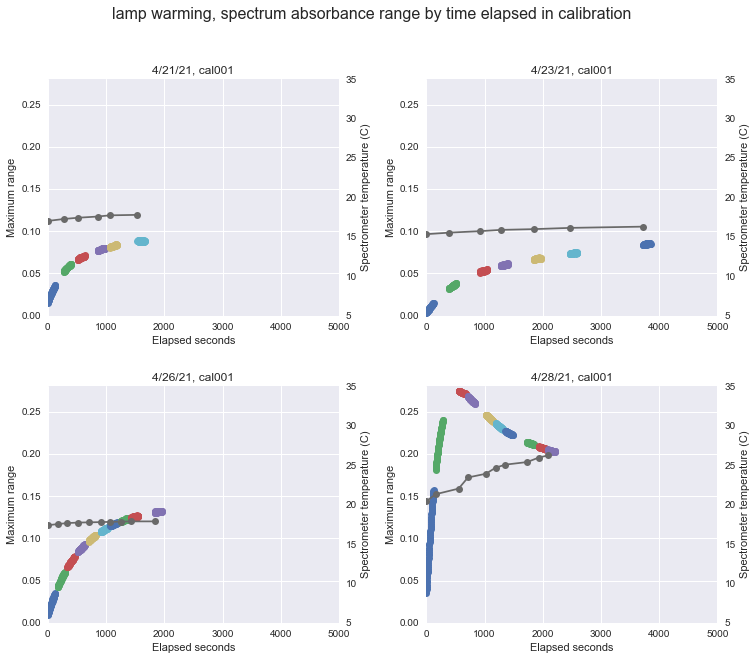

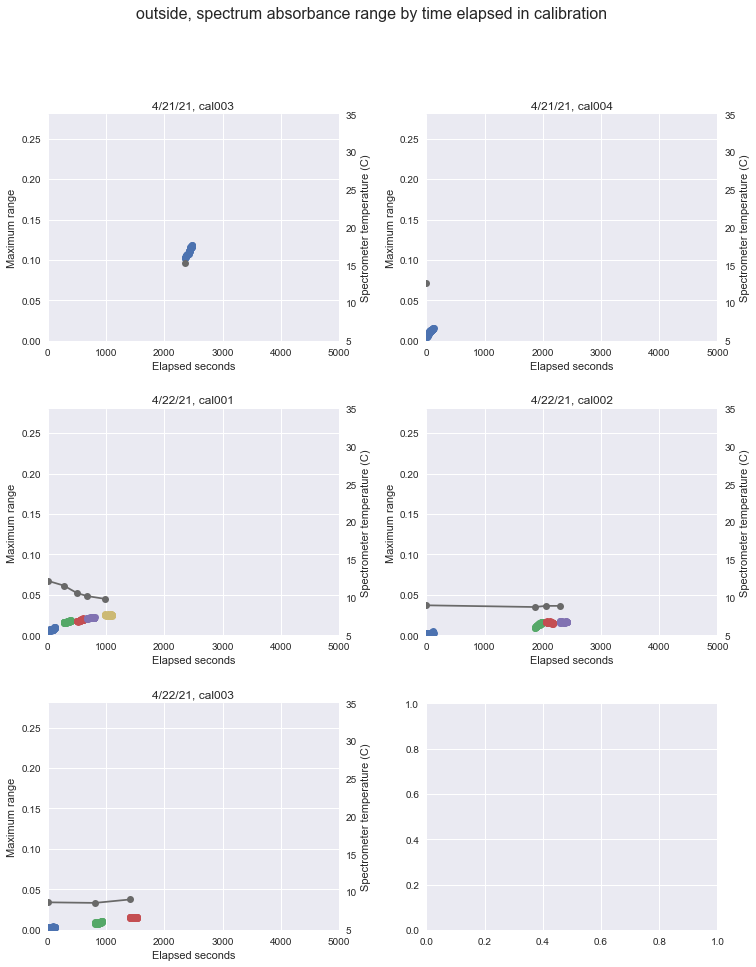

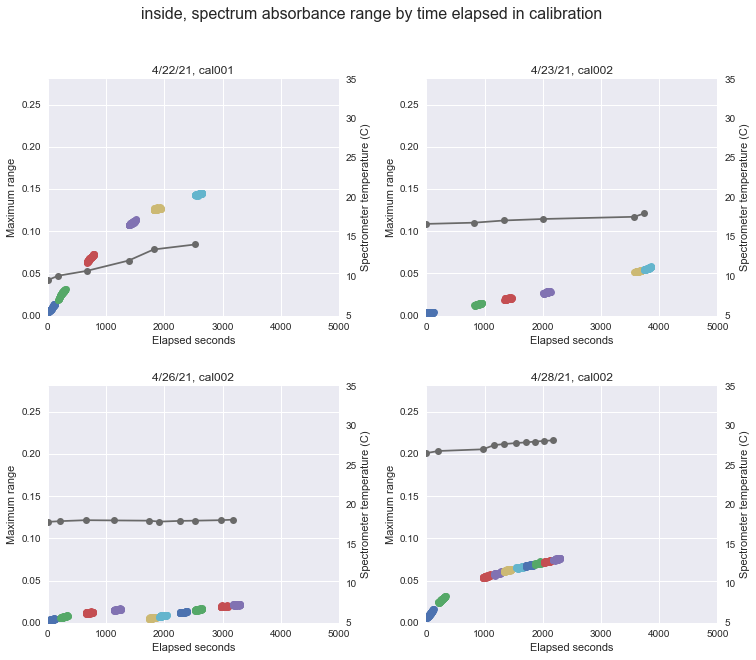

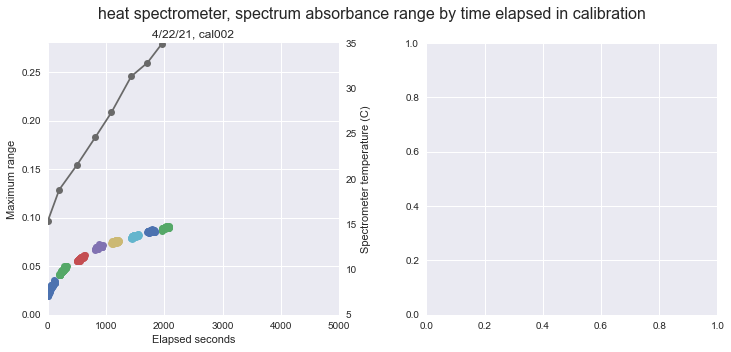

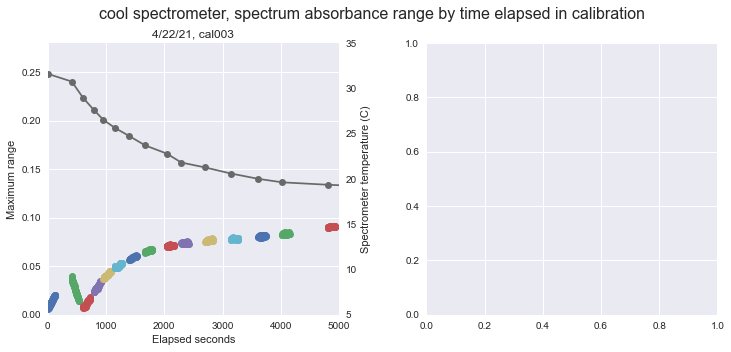

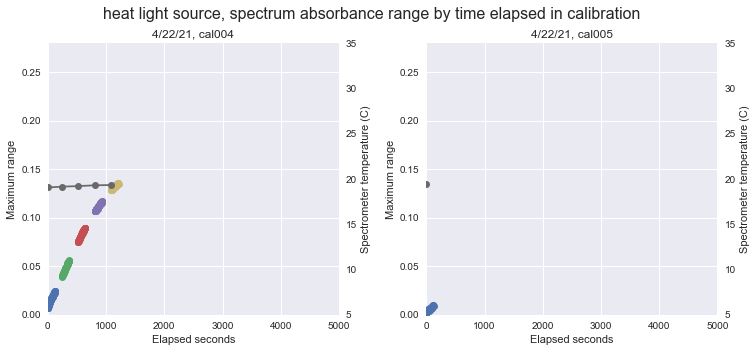

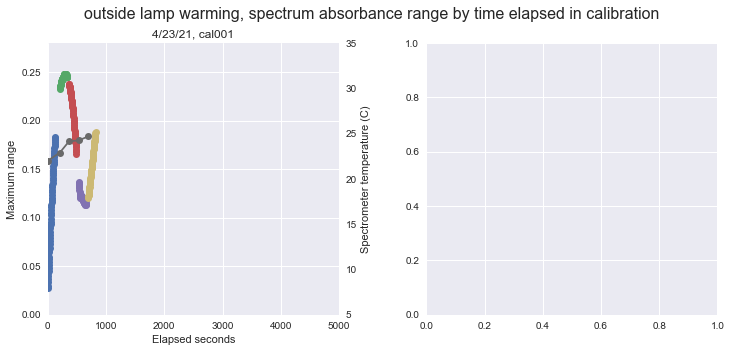

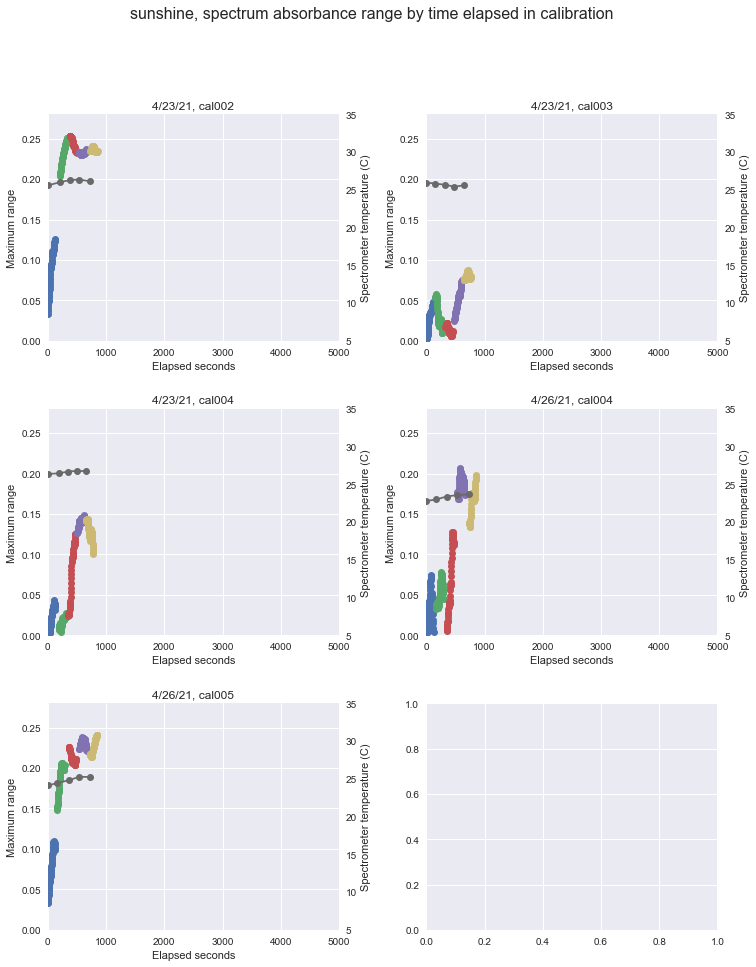

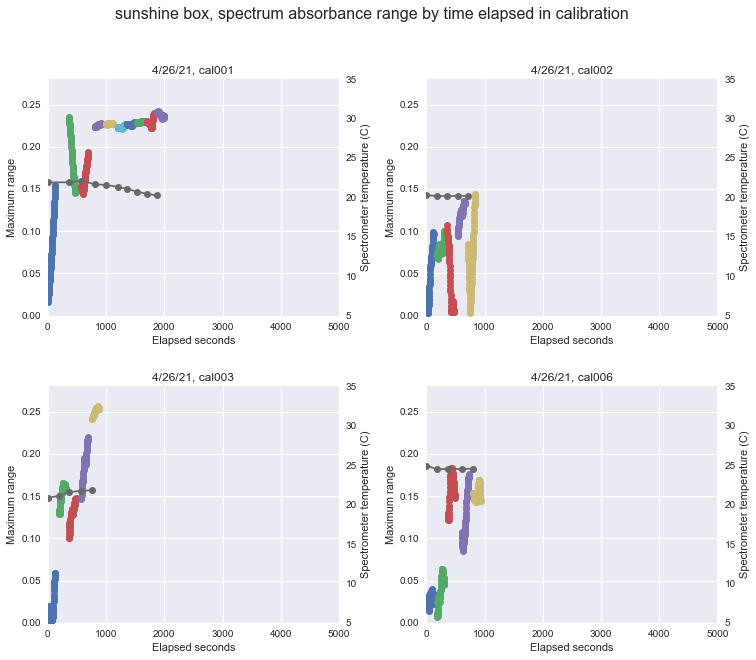

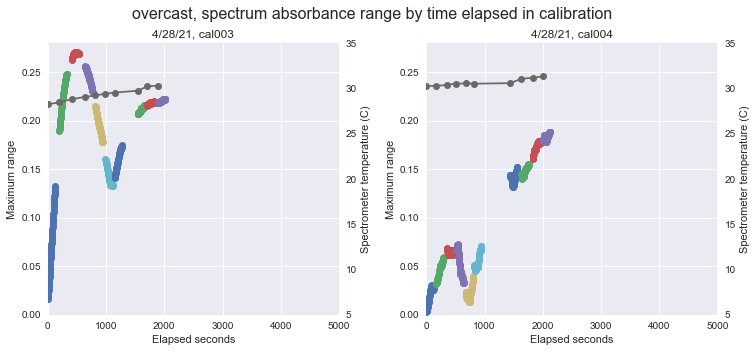

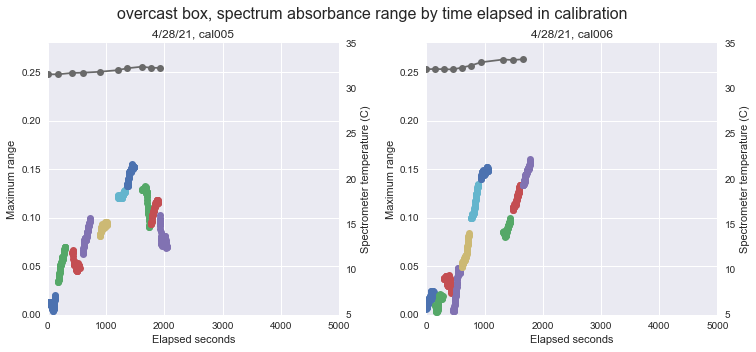

In [84]:
path_name = "/Users/linda/OneDrive/Documents/S4_mine_p/Projects/Data_collected/"
df = pd.read_csv('data/white_insertions.csv')
conditions = df['conditions'].unique()
for condition in conditions:
    inside_df = df.loc[df['conditions'] == condition].copy()
    calibrations_df = inside_df[['date', 'calibration']].drop_duplicates().copy()
    calibrations_count = calibrations_df.shape[0]
    records = list(calibrations_df.to_records(index=False))
    nrows = (calibrations_count // 2) + (calibrations_count % 2)
    fig_height = nrows * 5
    fig, axs = plt.subplots(nrows=nrows, ncols=2, figsize=(12, fig_height))
    fig.suptitle(f"{condition}, spectrum absorbance range by time elapsed in calibration", fontsize=16)
    for nn, ax in enumerate(axs.flat):
        try:
            date = records[nn][0]
            calibration = records[nn][1]        
            small_df = inside_df.loc[(inside_df['calibration'] == calibration) & (inside_df['date'] == date)].copy()
            file = construct_full_file_path(path_name, small_df['file_name'][small_df.index[0]])
            calibration_path = small_df['session'][small_df.index[0]] + '/' + small_df['calibration'][small_df.index[0]]
            calibration_insertions = create_list_of_insertions_in_calibration(file, calibration_path)
            calibration_date = small_df.iat[0, 1]    
            first_timestamp = get_ftir_spectrum_timestamp(file, calibration_insertions[0], 0)
            ax.set_title(f'{calibration_date}, {calibration}')
            ax.set_ylabel('Maximum range')
            ax.set_xlabel('Elapsed seconds')
            ax.set_ylim(0, 0.28)
            ax.set_xlim(0, 5000)
            ax2 = ax.twinx()
            ax2.set_ylabel('Spectrometer temperature (C)')

            ax2.set_ylim(5.0, 35.0)
            ax2.set_xlim(0, 5000)
            ax2.grid(b=None)
            
            temperature_df = pd.DataFrame()
            
            for index in small_df.index:  
                insertion_path = calibration_path + '/' + small_df['insertion'][index]
                insertion = small_df['insertion'][index]
                
                temperature_df.loc[index, 'insertion_temp'] = get_insertion_temperature(file, insertion_path)
                insertion_timestamp = get_ftir_spectrum_timestamp(file, insertion_path, 0)
                temperature_df.loc[index, 'time_delta'] = (insertion_timestamp - first_timestamp).total_seconds()
                
                insertion_start = get_insertion_timestamp(file, insertion_path)
                ftir_waves = get_ftir_wavelength_vector(file, calibration_path)
                start_index = find_position_in_wavelength_vector(ftir_waves, 1200)
                end_index = find_position_in_wavelength_vector(ftir_waves, 2200)
                ftir_raw_spectra = get_ftir_insertion_raw_spectra(file, insertion_path)
                ftir_white_spectrum = get_ftir_white_calibration_curve(file, calibration_path)[start_index:end_index]
                ftir_dark_spectrum = get_ftir_dark_calibration_curve(file, calibration_path)[start_index:end_index]
                ftir_absorbance_spectra = calculate_absorbance_for_2D_array(ftir_raw_spectra[:, start_index:end_index], ftir_white_spectrum, ftir_dark_spectrum)
                insertion_df = pd.DataFrame()

                for i in range(ftir_raw_spectra.shape[0]):
                    range_absorbance = np.ptp(ftir_absorbance_spectra[i, :])
                    spectrum_timestamp = get_ftir_spectrum_timestamp(file, insertion_path, i)
                    time_delta = spectrum_timestamp - first_timestamp
                    insertion_df.loc[i, "time_delta"] = time_delta.total_seconds()            
                    insertion_df.loc[i, "range_absorbance"] = range_absorbance
                # print(insertion_df.iloc[:, 0])
                ax.plot(insertion_df["time_delta"], insertion_df["range_absorbance"], 'o')
            ax2.plot(temperature_df["time_delta"], temperature_df["insertion_temp"], 'dimgray', marker='o')
        except:
            pass

    plt.subplots_adjust(hspace=0.3, wspace=0.3)
    plt.show()
    plt.close()

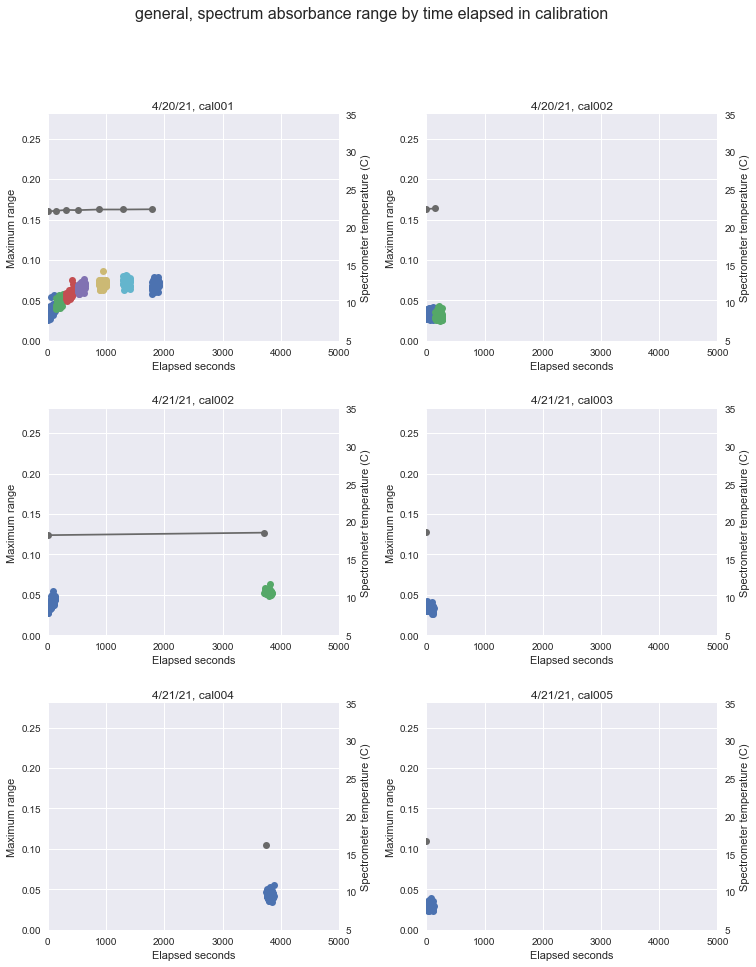

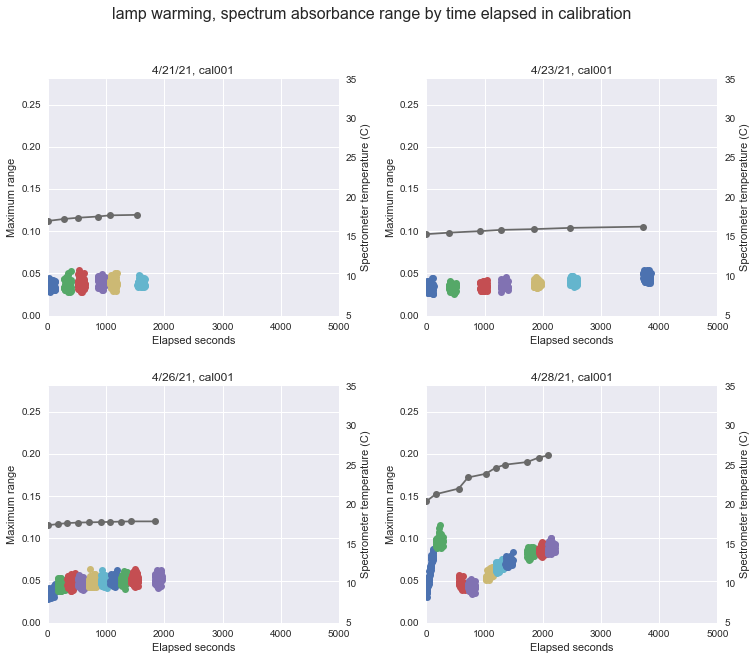

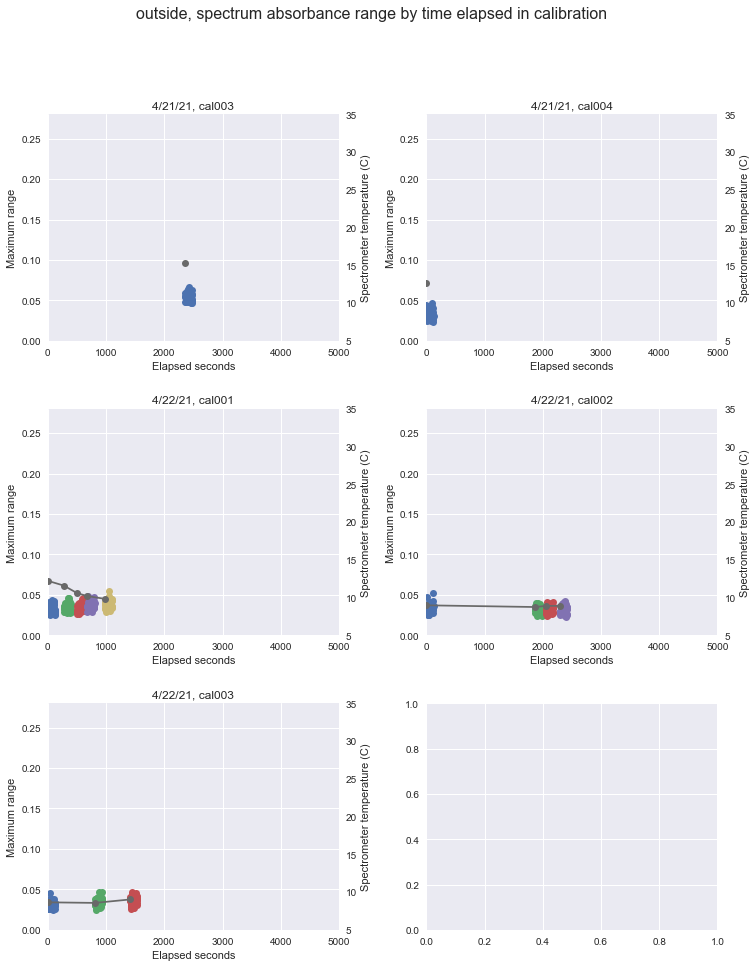

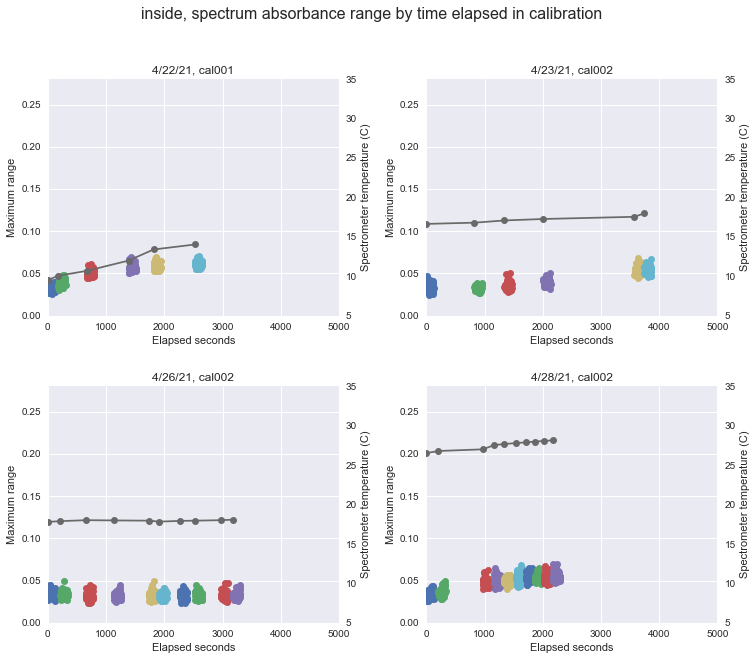

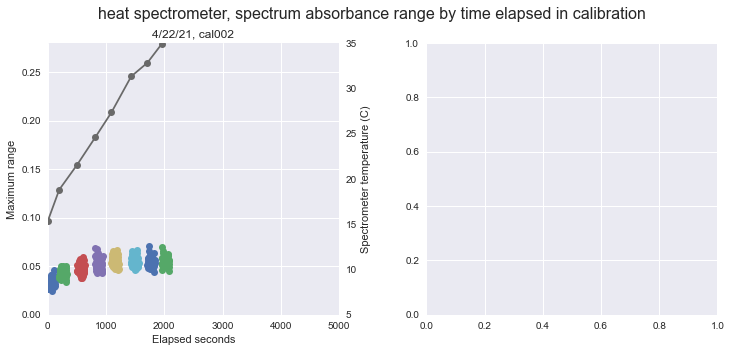

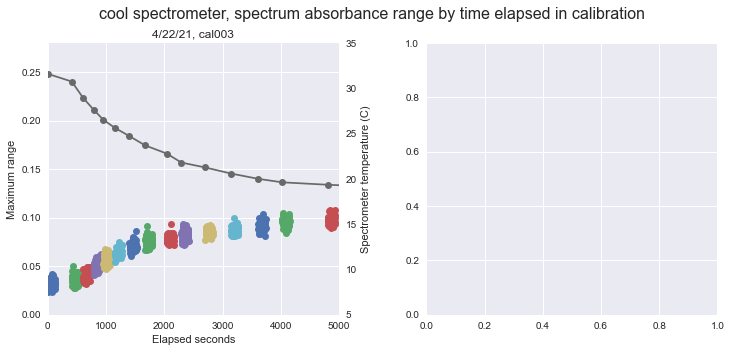

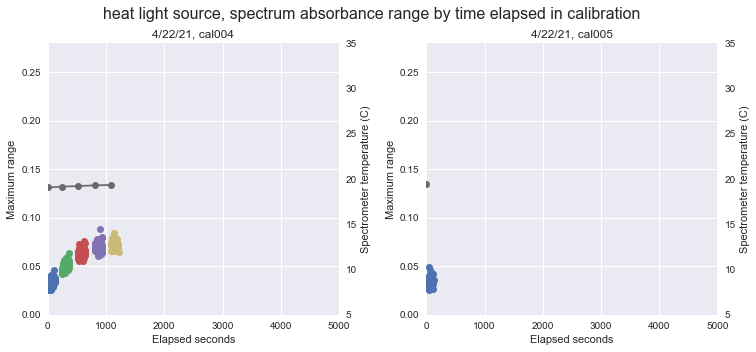

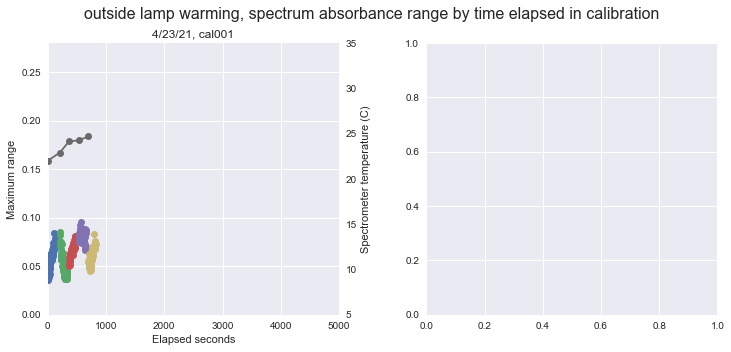

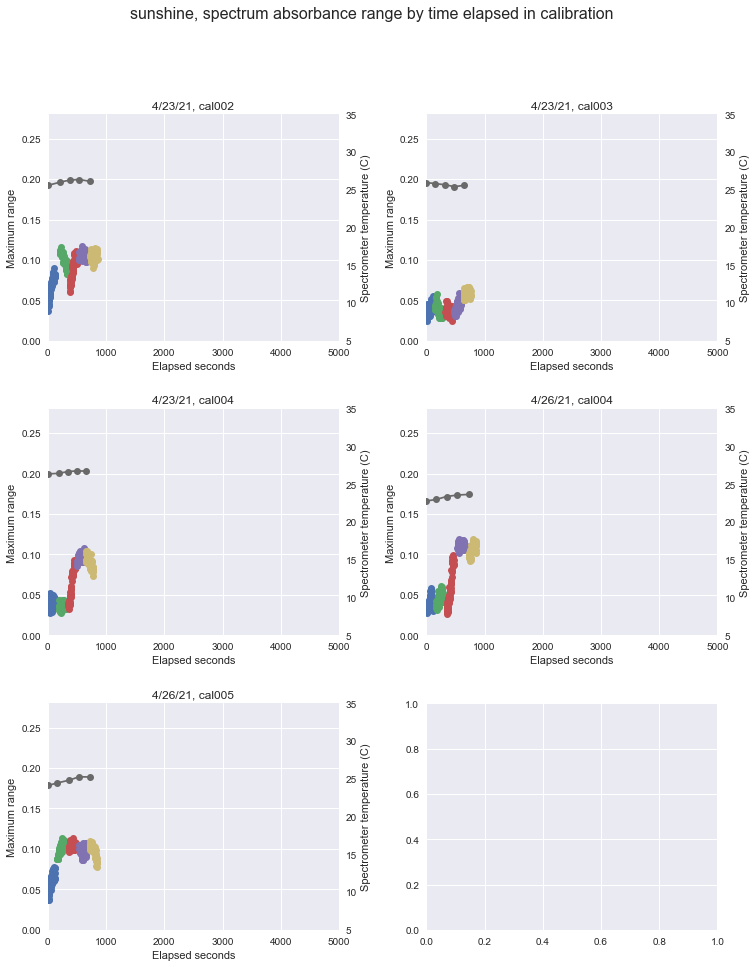

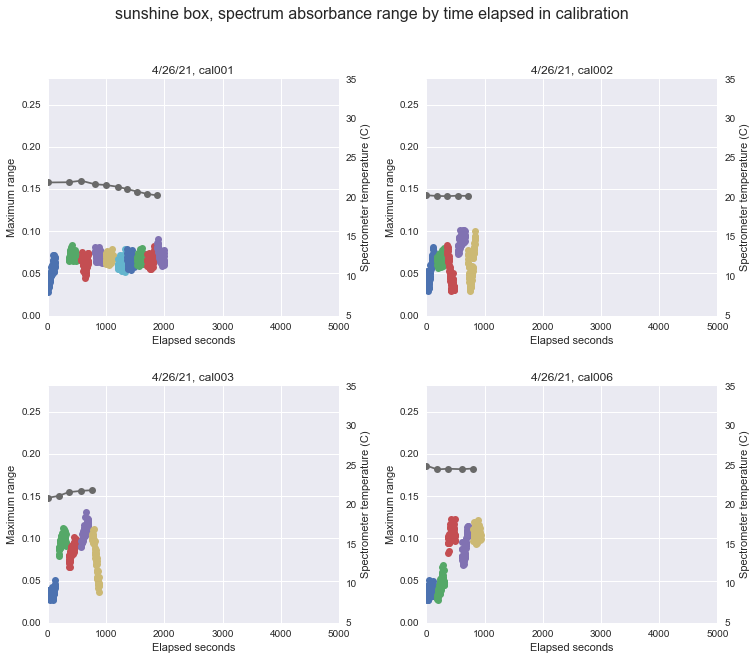

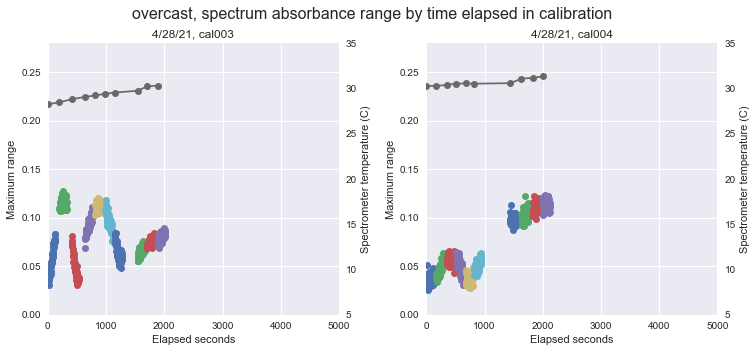

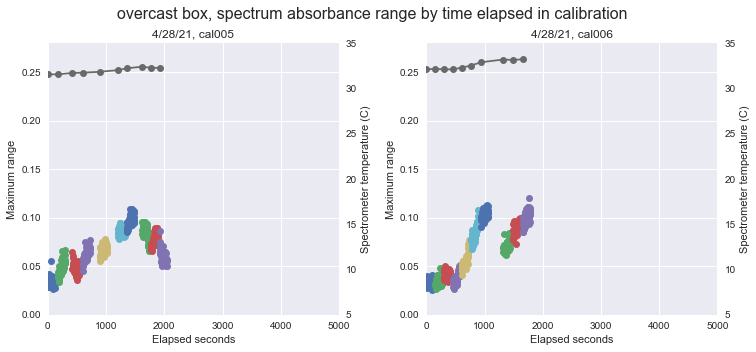

In [86]:
path_name = "/Users/linda/OneDrive/Documents/S4_mine_p/Projects/Data_collected/"
df = pd.read_csv('data/white_insertions.csv')
conditions = df['conditions'].unique()
for condition in conditions:
    inside_df = df.loc[df['conditions'] == condition].copy()
    calibrations_df = inside_df[['date', 'calibration']].drop_duplicates().copy()
    calibrations_count = calibrations_df.shape[0]
    records = list(calibrations_df.to_records(index=False))
    nrows = (calibrations_count // 2) + (calibrations_count % 2)
    fig_height = nrows * 5
    fig, axs = plt.subplots(nrows=nrows, ncols=2, figsize=(12, fig_height))
    fig.suptitle(f"{condition}, spectrum absorbance range by time elapsed in calibration", fontsize=16)
    for nn, ax in enumerate(axs.flat):
        try:
            date = records[nn][0]
            calibration = records[nn][1]        
            small_df = inside_df.loc[(inside_df['calibration'] == calibration) & (inside_df['date'] == date)].copy()
            file = construct_full_file_path(path_name, small_df['file_name'][small_df.index[0]])
            calibration_path = small_df['session'][small_df.index[0]] + '/' + small_df['calibration'][small_df.index[0]]
            calibration_insertions = create_list_of_insertions_in_calibration(file, calibration_path)
            calibration_date = small_df.iat[0, 1]    
            first_timestamp = get_ftir_spectrum_timestamp(file, calibration_insertions[0], 0)
            ax.set_title(f'{calibration_date}, {calibration}')
            ax.set_ylabel('Maximum range')
            ax.set_xlabel('Elapsed seconds')
            ax.set_ylim(0, 0.28)
            ax.set_xlim(0, 5000)
            ax2 = ax.twinx()
            ax2.set_ylabel('Spectrometer temperature (C)')

            ax2.set_ylim(5.0, 35.0)
            ax2.set_xlim(0, 5000)
            ax2.grid(b=None)
            
            temperature_df = pd.DataFrame()
            
            for index in small_df.index:  
                insertion_path = calibration_path + '/' + small_df['insertion'][index]
                insertion = small_df['insertion'][index]
                
                temperature_df.loc[index, 'insertion_temp'] = get_insertion_temperature(file, insertion_path)
                insertion_timestamp = get_ftir_spectrum_timestamp(file, insertion_path, 0)
                temperature_df.loc[index, 'time_delta'] = (insertion_timestamp - first_timestamp).total_seconds()
                
                insertion_start = get_insertion_timestamp(file, insertion_path)
                vis_waves = get_visible_wavelength_vector(file, calibration_path)
                start_index = find_position_in_wavelength_vector(vis_waves, 500)
                end_index = find_position_in_wavelength_vector(vis_waves, 1000)
                vis_raw_spectra = get_visible_insertion_raw_spectra(file, insertion_path)
                vis_white_spectrum = get_visible_white_calibration_curve(file, calibration_path)[start_index:end_index]
                vis_dark_spectrum = get_visible_dark_calibration_curve(file, calibration_path)[start_index:end_index]
                vis_absorbance_spectra = calculate_absorbance_for_2D_array(vis_raw_spectra[:, start_index:end_index], vis_white_spectrum, vis_dark_spectrum)
                insertion_df = pd.DataFrame()

                for i in range(vis_raw_spectra.shape[0]):
                    range_absorbance = np.ptp(vis_absorbance_spectra[i, :])
                    spectrum_timestamp = get_visible_spectrum_timestamp(file, insertion_path, i)
                    time_delta = spectrum_timestamp - first_timestamp
                    insertion_df.loc[i, "time_delta"] = time_delta.total_seconds()            
                    insertion_df.loc[i, "range_absorbance"] = range_absorbance
                # print(insertion_df.iloc[:, 0])
                ax.plot(insertion_df["time_delta"], insertion_df["range_absorbance"], 'o')
            ax2.plot(temperature_df["time_delta"], temperature_df["insertion_temp"], 'dimgray', marker='o')
        except:
            pass

    plt.subplots_adjust(hspace=0.3, wspace=0.3)
    plt.show()
    plt.close()